## MCC NMIBC Pre-repeat Urine MRD analysis

In [16]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=100)
source("../fix_PIDs.R")

# set some defaults
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=100)
formals(table)$useNA <- "always"

print(Sys.time())
print(sessionInfo())

[1] "2024-06-06 13:36:58 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 14.4.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggsignif_0.6.4        glue_1.7.0            pROC_1.18.4          
 [4] readxl_1.4.3          RColorBrewer_1.1-3    maftools_2.16.0      
 [7] ComplexHeatmap_2.16.0 lubridate_1.9.2       forcats_1.0.0        
[10] stringr_1.5.1         dplyr_1.1.4           purrr_1.0.2          
[13] readr_2.1.4           tidyr_1.3.1           tibble_3.2.1         
[16] tidyverse_

### pipeline notes on the mrd output file, see deepsea func callMRD and local annotated version of function
- mutationCount = length(variants.f), # count of Beacon sample variants that are somatic, and finalKeep or white.list
- mutationCount.mrd = length(variants.mrd), # number of quality filtered T00 personalized variants detected           
- mutationCount.mrd.f = length(variants.mrd.sig), ## number filtered T00 personal variants that have changed signif. in freuqncy from baseline (i.e. are not germlines mistaken for somatics)                       
- mrd.status = mrd.status,  ## total mrd.score across variants is >1.5
- tumorFraction = tumorFraction, # beacon sample tumorFraction calculated from variants.mrd.sig.f markers, or if none calculated from the other baseline-matching variants

In [352]:
# read in clinical data

## functions for harmonizing input sheets
source("../fix_PIDs.R")

fix_sampleTypes <- function(col){
  print(table(col, useNA="always"))
  col.new <- tolower(col)
  col.new <- gsub("ffpe", "tissue", col.new)
  col.new <- gsub("urine_supernatant|supernatant", "urine", col.new) 
  col.new <- gsub("pbmc|buffycoat", "buffy_coat", col.new)
  print(table(col.new, useNA="always"))
  return(col.new)
}

fix_StudyVisit <- function(col){
    warn_na(col)
    col.new <- sapply(str_split(col, pattern="_"), "[", 2)
    return(col.new)
}

# read in clinical data
df_clin.new = read.csv("clinical_data/NMIBC_clinical_data_merged_2024-06-18_BG_JL.csv")
#df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(PatientID = as.character(fix_PIDs(PatientID)))

sort(names(df_clin.new))
table(df_clin.new$PatientID)
stopifnot(all(!duplicated(df_clin.new$PatientID)))

 [1] "76224"  "116381" "152237" "161922" "165028" "167162" "169558" "171374"
 [9] "171769" "171821" "172153" "172229" "172530" "172586" "172602" "172749"
[17] "172851" "173075" "173254" "173281" "173334" "173350" "173359" "173362"
[25] "173509" "173743" "173912" "173975" "173983" "174083" "174091" "174872"
[33] "174947" "175325" "175387" "175425" "175492" "175526" "175610" "175648"
[41] "175672" "175725" "175733" "175831" "175854" "175980" "176349" "176388"
[49] "176828" "176992" "177967" "178886" "178919" "179692" "180264" "181439"
[57] "181568" "182022" "182170" "182435" "182910" "184289" "184485" "184615"
[65] "184957" "185014" "185159" "185212" "185382" "185581" "186478" "186652"
[73] "187204" "187260" "187807" "188867" "189083" "189342" "189953" "190233"
[81] "191632" "191692" "192682" "193186" "193187" "193248" "193330" "194171"
[89] "194650" "195312" "195407" "195451" "195778" "195874" "196111" "196412"


[1] "Age"                                                                                                            
 [2] "any_progression"                                                                                                
 [3] "Clinical.Recurrence."                                                                                           
 [4] "Complete."                                                                                                      
 [5] "CytoscopyDate"                                                                                                  
 [6] "Date.of.Subsequent.TURBT"                                                                                       
 [7] "disease.positive"                                                                                               
 [8] "ECOG.scoreAt.Repeat.TURBT"                                                                                      
 [9] "germline.seq.method"                                                                                            
[10] "has.IndexTURBT"                                                                                                 
[11] "Immediate.Post.Op.Intravesical.Therapy.Index"                                                                   
[12] "Immediate.Post.Op.Intravesical.Therapy.Repeat"                                                                  
[13] "index_to_recurrence"                                                                                            
[14] "index_to_repeat"                                                                                                
[15] "Index.CIS"                                                                                                      
[16] "Index.Stage"                                                                                                    
[17] "Index.TURBT.Date"                                                                                               
[18] "IndexGrade"                                                                                                     
[19] "IndexHistology"                                                                                                 
[20] "Induction.Cycles"                                                                                               
[21] "Induction.Intravesical.Therapy.Administered."                                                                   
[22] "Induction.Intravesical.Therapy.Type."                                                                           
[23] "LVI...35"                                                                                                       
[24] "LVI...43"                                                                                                       
[25] "Maintenance.Duration..Pick.Closest.Time.Point."                                                                 
[26] "Maintenance.Intravesical.Therapy."                                                                              
[27] "Maintenance.Intravesical.Therapy.Type."                                                                         
[28] "mibc_progression"                                                                                               
[29] "Other.Intravesical.Therapy"                                                                                     
[30] "pathologic_recurrence"                                                                                          
[31] "PatientID"                                                                                                      
[32] "PatientID.old"                                                                                                  
[33] "Previous.history.of.NMIBC"                                                                                      
[34] "Previous.Intravesical.Therapy..choice.BCG."                         


116381 152237 161922 165028 167162 169558 171374 171769 171821 172153 172229 
     1      1      1      1      1      1      1      1      1      1      1 
172530 172586 172602 172749 172851 173075 173254 173281 173334 173350 173359 
     1      1      1      1      1      1      1      1      1      1      1 
173362 173509 173743 173912 173975 173983 174083 174091 174872 174947 175325 
     1      1      1      1      1      1      1      1      1      1      1 
175387 175425 175492 175526 175610 175648 175672 175725 175733 175831 175854 
     1      1      1      1      1      1      1      1      1      1      1 
175980 176349 176388 176828 176992 177967 178886 178919 179692 180264 181439 
     1      1      1      1      1      1      1      1      1      1      1 
181568 182022 182170 182435 182910 184289 184485 184615 184957 185014 185159 
     1      1      1      1      1      1      1      1      1      1      1 
185212 185382 185581 186478 186652 187204 187260 187807 188867 

In [354]:
# Master sample list from manifests
df_samples_all = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_06072024.xlsx", sheet="all_Recieved_samples_FZ") %>%
    #"./NMIBC_Sample_Inventory_and_QC_11092023.xlsx", sheet="Sample information real time") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType)) %>%
                filter(!is.na(SampleID))
print("recieved samples")
table(df_samples_all$SampleType, df_samples_all$StudyVisit, useNA="always")
stopifnot(all(!(duplicated(df_samples_all$SampleID.short)))) #253
nrow(df_samples_all) # 680

# Lab QC
print("extracted samples")
df_lab_qc = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_06072024.xlsx", sheet="LabQC") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
table(df_lab_qc$SampleType, df_lab_qc$StudyVisit, useNA="always")
stopifnot(all(!duplicated(df_lab_qc$SampleID)))
nrow(df_lab_qc) #369 samples

SampleID.short format: strict
 [1] "76224"  "116381" "152237" "161922" "165028" "167162" "169558" "171374"
 [9] "171769" "171821" "172153" "172229" "172530" "172586" "172602" "172749"
[17] "172851" "173075" "173254" "173281" "173334" "173350" "173359" "173362"
[25] "173509" "173743" "173912" "173975" "173983" "174083" "174091" "174872"
[33] "174947" "175325" "175387" "175425" "175492" "175526" "175610" "175648"
[41] "175672" "175725" "175733" "175831" "175854" "175980" "176349" "176388"
[49] "176828" "176992" "177967" "178886" "178919" "179692" "180264" "181439"
[57] "181568" "182022" "182170" "182435" "182910" "184289" "184485" "184615"
[65] "184957" "185014" "185159" "185212" "185382" "185581" "186478" "186652"
[73] "187204" "187260" "187807" "188867" "189083" "189342" "189953" "190233"
[81] "191632" "191692" "192682" "193186" "193187" "193248" "193330" "194171"
[89] "194650" "195312" "195407" "195451" "195778" "195874" "196111" "196412"


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 620 rows [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 19, 20,
21, 22, 23, ...].”


col
        Buffycoat              FFPE            Plasma       Supernatant 
               92               155                92               161 
           Tissue Urine Cell Pellet              <NA> 
               20               160                 0 
col.new
       buffy_coat            plasma            tissue             urine 
               92                92               175               161 
urine cell pellet              <NA> 
              160                 0 
[1] "recieved samples"


                   
                    BenignUrothelium FollowUp1 FollowUp2 FollowUp3 Followup4
  buffy_coat                       0         0         0         0         0
  plasma                           0         0         0         0         0
  tissue                           9         0         0         0         0
  urine                            0        18         9         4         1
  urine cell pellet                0        18         9         4         1
  <NA>                             0         0         0         0         0
                   
                    IndexTURBT PostTURBT Pre-RepeatTURBT RepeatTURBT
  buffy_coat                 0         0              92           0
  plasma                     0         0              92           0
  tissue                    94         0               0          72
  urine                      0        30              96           0
  urine cell pellet          0        29              96           0
  <NA> 

[1] 680

[1] "extracted samples"
SampleID.short format: strict
 [1] "172602" "172851" "172586" "173983" "173359" "169558" "161922" "172530"
 [9] "173362" "172153" "172229" "173334" "171374" "173509" "171769" "175610"
[17] "175492" "152237" "176992" "177967" "173350" "178886" "175526" "175733"
[25] "175725" "171821" "174083" "182022" "174872" "175425" "176388" "175854"
[33] "175980" "175672" "173975" "173912" "176349" "174947" "176828" "180264"
[41] "172749" "175325" "165028" "167162" "175387" "175648" "173254" "174091"
[49] "173281" "173075" "116381" "182910" "179692" "181439" "181568" "184485"
[57] "175831" "185014" "184615" "184289" "184957" "186652" "185581" "185382"
[65] "185212" "182435" "187204" "186478" "187807" "188867" "189342" "189083"
[73] "190233" "191692" "191632" "192682" "193186" "196111" "196412" "195312"
[81] "195407" "195874" "194171" "195778" "195451" "194650" "193330" "193187"
[89] "193248" "189953" "187260" "185159" "182170" "178919" "173743" "76224" 


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 329 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
19, 20, ...].”


col
       Buffy_Coat              FFPE              PBMC            Plasma 
               58                52                15                15 
           Tissue               UCP             Urine Urine_Supernatant 
              106                28                29               131 
             <NA> 
                0 
col.new
buffy_coat     plasma     tissue        ucp      urine       <NA> 
        73         15        158         28        160          0 


            
             BenignUrothelium FollowUp1 FollowUp2 FollowUp3 IndexTURBT
  buffy_coat                0         0         0         0          0
  plasma                    0         0         0         0          0
  tissue                    9         0         0         0         73
  ucp                       0         0         0         0          0
  urine                     0        18         9         4          0
  <NA>                      0         0         0         0          0
            
             PostTURBT Pre-RepeatTURBT RepeatTURBT Surveillance1 <NA>
  buffy_coat         0              73           0             0    0
  plasma             0              15           0             0    0
  tissue             0               0          31             0   45
  ucp               10              15           0             3    0
  urine             30              96           0             3    0
  <NA>               0               0           0       

[1] 434

# Pre-repeat Urine MRD

In [377]:
## all mrd data::
df.mrd.all = read.csv("data_delivery/BEACON/PRDC-NMIBC_BEACON_MRD_all_urine_UCP_results_2024-06-18.csv") # one ucp remaining
# this urine MRD sample is reported, but had very low/weird sequencing quality. use only LPdata. use UCP for MRD
df.mrd.all = df.mrd.all %>% filter(SampleID != "P217594") 

df.mrd.preur = df.mrd.all %>% filter(StudyVisit.baseline == "IndexTURBT", 
                                   StudyVisit.sample == "Pre-RepeatTURBT",
                                   SampleType.sample != "buffy_coat") %>%
                              select(-germline.seq.method)
df.mrd.preur[df.mrd.preur=="NA"] <- NA
length(unique(df.mrd.all$PatientID.sample)) #88
df.mrd.preur = df.mrd.preur %>% mutate(PatientID=as.character(PatientID.sample),
                                       across(all_of(c("tumorFraction.pipeline.PERCENT",
                                                       "tumorFraction.mrd.PERCENT",
                                                       "tf.m.f.PERCENT","mutationCount",
                                                       "tumorFraction.final.PERCENT")), as.numeric))
### add lpwgs
df_lpwgs.all = read.csv("data_delivery/LPWGS/PRDC-MOFFITT-NMIBC-22001_LPWGS_WC_Summary_combined_2024-05-23.csv", as.is=T) %>%
        mutate(SampleID.short = make_SIDshort(SampleID, "strict"),
               across(all_of(c('wgsTumorfrac_ichorCNA','armAbnormalityScore','fragmentNum','cnbScore','wgsTumorfrac_EM')),
                     as.numeric)) %>%
        select("SampleID.short",'wgsTumorfrac_ichorCNA','armAbnormalityScore',
               'fragmentNum','cnbScore','wgsTumorfrac_EM',"qcLabel","classificationLabel") %>%
        rename("lpwgs.qc"="qcLabel") %>%
        filter(!is.na(SampleID.short)) %>%
        left_join(df_samples_all %>% select(SampleID.short, SampleType, StudyVisit, PatientID), by="SampleID.short", suffix=c("",".y")) %>% select(-ends_with(".y"))

df_lpwgs.preur = df_lpwgs.all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="urine") %>%
                    rename("SampleType.sample"="SampleType",
                          "SampleID.short.sample"="SampleID.short",
                          "StudyVisit.sample"="StudyVisit")
        
df.mrd.preur = df.mrd.preur %>% full_join(df_lpwgs.preur, by=c("SampleID.short.sample","SampleType.sample",
                                                               "StudyVisit.sample","PatientID"))

# add clin data
df.mrd.preur = df.mrd.preur %>% left_join(df_clin.new %>% select(PatientID, Repeat.Stage, Index.Stage,Index.CIS, Repeat.CIS, germline.seq.method), 
                                   by="PatientID") %>%
                          mutate(disease.positive.bin = ifelse(disease.positive=="TRUE",1,0)) %>%
                          select(-SampleID)

table(df.mrd.preur$PatientID)
if (any(duplicated(df.mrd.preur$PatientID))){
    print(glue("duplicated urine/ucp: {df.mrd.preur$PatientID[duplicated(df.mrd.preur$PatientID)]}"))

}

# from shared MCC planning doc 5/21/2024 for cross check
mrd.patients = sort(c("76224","116381","152237","161922","167162","169558",
                      "171374","171769","171821","172229","172530","172602","172749","172851","173743",
                           "173912","173975","173983","174083","174091","174872","175325","175387","175425",
                           "175492","175648","175672","175725","175831","175854","175980","176349","176388",
                           "177967","178919","179692",
                      "180264","181439","181568","182022","182170","182435",
                           "182910","184289","184485","184615","184957","175610","175733","176992","178886",
                           "185159","185212","185382","185581","186478","186652","187204","187807","188867","189083","189342",
                           "189953",
                      "190233","191632","193186","193187","193248","193330","194650",
                           "195312","195407","195451","195778","195874","196111","196412",
                      "173334","173075","175526","192682","173362","173350","178886","169558","194171")) # ucps last
length(mrd.patients) #86 patients w mrd data
mrd.patients[mrd.patients %!in% df.mrd.preur$PatientID]

# to add UCP 
# 194171 - have urine LPWGS, UCP still in process

sort(names(df.mrd.preur))

## patients excluded
# 187260 - not enough urine for mrd (wes only)
# 194171 - no MRD seq, no LPWGS, ucfDNA yield low - process UCP??
# 173362 - number of index variants too low (=5) - exclude for mrd
#"173350", prUR mislabeled - exclude
#"176828", # 176828 - low ucfDNA, repeat probes only
#"173281", # repeat TURBT probes only, Index fail                     
#"173509", # prUR ex qc fail
#"174947", # repeat probes only, Index fail

# other sample notes
# 173281 - PBMC fail, analyze separate - ok for mrd
# 152237 - low quality germline - PBMC extraction pass sample P228635 - ngsqc pass: likely mislabeled, use as no PBMC


[1] 88

SampleID.short format: strict



116381 152237 161922 165028 167162 169558 171374 171769 171821 172153 172229 
     1      1      1      1      1      2      1      1      1      1      1 
172530 172586 172602 172749 172851 173075 173254 173281 173334 173350 173359 
     1      1      1      1      1      1      1      1      1      1      1 
173362 173509 173743 173912 173975 173983 174083 174091 174872 174947 175325 
     1      2      1      1      1      1      1      1      1      1      1 
175387 175425 175492 175526 175610 175648 175672 175725 175733 175831 175854 
     1      1      1      1      1      1      1      1      1      1      1 
175980 176349 176388 176828 176992 177967 178886 178919 179692 180264 181439 
     1      1      1      1      1      1      1      1      1      1      1 
181568 182022 182170 182435 182910 184289 184485 184615 184957 185159 185212 
     1      1      1      1      1      1      1      1      1      1      1 
185382 185581 186478 186652 187204 187260 187807 188867 189083 

duplicated urine/ucp: 169558
duplicated urine/ucp: 173509


[1] 86

character(0)

[1] "armAbnormalityScore"            "classificationLabel"           
 [3] "cnbScore"                       "cohort"                        
 [5] "disease.positive"               "disease.positive.bin"          
 [7] "fragmentNum"                    "germline.seq.method"           
 [9] "has.preUR.methyl.data"          "includeNovel"                  
[11] "Index.CIS"                      "Index.Stage"                   
[13] "lpwgs.qc"                       "methyl.method"                 
[15] "mutationCount"                  "mutationCount.mrd"             
[17] "mutationCount.mrd.f"            "PatientID"                     
[19] "PatientID.baseline"             "PatientID.sample"              
[21] "Recurrence.Follow.Up"           "Repeat.CIS"                    
[23] "Repeat.Stage"                   "Repeat.Tumor"                  
[25] "SampleID.short.baseline"        "SampleID.short.sample"         
[27] "SampleType.baseline"            "SampleType.sample"             
[29] "seq.set"                        "StudyVisit.baseline"           
[31] "StudyVisit.sample"              "tf.m.f.PERCENT"                
[33] "tumorFraction.final.PERCENT"    "tumorFraction.mrd.PERCENT"     
[35] "tumorFraction.pipeline.PERCENT" "wgsTumorfrac_EM"               
[37] "wgsTumorfrac_ichorCNA"

In [378]:
## cohort summary
# annotate mrd.data with urine wes.baseline info etc.
######
cohort.summary.wes = read.csv("data_delivery/cohort_summary_WES_2024-06-18.csv", as.is=T) %>%
    mutate(PatientID=as.character(PatientID)) %>% select(-has.pbmc.wes) 
table(cohort.summary.wes$has.Urine.wes)
# FALSE  TRUE  <NA> 
#    32    63     0 
df.mrd.preur = df.mrd.preur %>% mutate(has.preUR.Panel.TF = !is.na(tumorFraction.final.PERCENT), 
                                             has.preUR.LPWGS.TF = !is.na(cnbScore))

cohort.summary_ = cohort.summary.wes %>% full_join(df.mrd.preur, by="PatientID", suffix=c("",".y")) %>%
                    select(-ends_with(".y"))
table(cohort.summary_$germline.seq.method)
cohort.summary_ = cohort.summary_ %>%
                    rename("SampleType.preUR"="SampleType.sample", 
                           "tumorFraction.preUR.final.PERCENT"="tumorFraction.final.PERCENT",
                           "cnbScore.preUR"="cnbScore",
                           "wgsTumorfrac_ichorCNA.preUR"="wgsTumorfrac_ichorCNA") %>%
                    relocate(PatientID, benign, has.Index.wes, has.Repeat.wes, has.Urine.wes,
                             germline.seq.method,
                             has.preUR.Panel.TF, SampleType.preUR, tumorFraction.preUR.final.PERCENT, 
                             has.preUR.LPWGS.TF, cnbScore.preUR, wgsTumorfrac_ichorCNA.preUR)
head(cohort.summary_)
table(cohort.summary_$PatientID)
dim(table(cohort.summary_$PatientID)) #96 pats
write.csv(cohort.summary_, glue("data_delivery/cohort_summary_Extended_{Sys.Date()}.csv"), row.names=FALSE)



FALSE  TRUE  <NA> 
   32    63     0 


MRD.panel      WES+      <NA> 
       19        71         7 

,PatientID,benign,has.Index.wes,has.Repeat.wes,has.Urine.wes,germline.seq.method,has.preUR.Panel.TF,SampleType.preUR,tumorFraction.preUR.final.PERCENT,has.preUR.LPWGS.TF,cnbScore.preUR,wgsTumorfrac_ichorCNA.preUR,Recurrence.Follow.Up,Repeat.Tumor,disease.positive,has.IndexTURBT,Age,Sex,Race,Smoking.Status,ECOG.scoreAt.Repeat.TURBT,Previous.pelvic.XRT,Previous.history.of.NMIBC,Progression,Previous.Intravesical.Therapy..choice.None.,Previous.Intravesical.Therapy..choice.BCG.,Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.,Previous.Intravesical.Therapy..choice.Mitomycin.C.,Other.Intravesical.Therapy,Prior.Treatment.Free.Text..1.2.sentence.summary.of.treatment.prior.to.Index.TURBT.inclusive.of.NMIBC.Pathology.,Index.TURBT.Date,IndexHistology,Variant.Histology,Index.Stage,IndexGrade,Index.CIS,LVI...35,Immediate.Post.Op.Intravesical.Therapy.Index,⋯,TURBT.Recurrence.Pathology,PatientID.old,index_to_repeat,pathologic_recurrence,index_to_recurrence,total_time,upfront_cystectomy,any_progression,mibc_progression,group1.index_repeat_paired,group2.index_urine_paired,group3.index_repeat_urine_trio,JL.excluded,StudyVisit.sample,StudyVisit.baseline,mutationCount,mutationCount.mrd,mutationCount.mrd.f,includeNovel,tumorFraction.pipeline.PERCENT,tumorFraction.mrd.PERCENT,tf.m.f.PERCENT,seq.set,has.preUR.methyl.data,methyl.method,SampleID.short.sample,SampleID.short.baseline,PatientID.sample,PatientID.baseline,SampleType.baseline,cohort,armAbnormalityScore,fragmentNum,wgsTumorfrac_EM,lpwgs.qc,classificationLabel,disease.positive.bin
,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<int>,<int>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,173983,FALSE,TRUE,TRUE,FALSE,WES+,TRUE,urine,0.1950100,TRUE,5.685603,0.0000,0,5,TRUE,1,68,FEMALE,WHITE,Never Smoker,ECOG 1,No,No,No Prior NMIBC,No,No,No,No,,,1/27/22,Urothelial,Yes,T1HG,High,None,No,No,⋯,,173983,1.4,Yes,9.8,6.7,Yes,Yes,Yes,TRUE,FALSE,FALSE,FALSE,Pre-RepeatTURBT,IndexTURBT,38,36,36,1,0.1950100,0.19501029,0.022549160,1n2,TRUE,EPIC,P217592,P220085,173983,173983,tissue,discovery,55.043,2358302,0.0000000,Pass,lowRisk,1
2,173334,FALSE,TRUE,TRUE,FALSE,WES+,TRUE,urine,0.0107450,TRUE,3.521956,0.0000,0,3,TRUE,1,78,MALE,WHITE,Former Smoker,ECOG 0,No,No,No Prior NMIBC,No,No,No,No,,,12/1/21,Urothelial,No,T1HG,High,None,No,No,⋯,,173334,1.2,No,NA,26.9,No,No,No,TRUE,FALSE,FALSE,FALSE,Pre-RepeatTURBT,IndexTURBT,76,73,70,1,0.0107450,0.01074472,0.002797925,1n2,TRUE,EPIC,P219771,P220076,173334,173334,tissue,discovery,22.463,2382513,0.0000000,Pass,lowRisk,1
3,172586,FALSE,TRUE,TRUE,TRUE,WES+,FALSE,urine,NA,TRUE,9.927298,0.3565,1,4,TRUE,1,90,MALE,WHITE,Former Smoker,ECOG 1,No,Yes,No,No,Yes,No,No,NA,BCG in late 2021,8/10/21,Urothelial,No,T1HG,High,None,No,No,⋯,TaHG,172586,1.3,No,NA,24.7,No,No,No,TRUE,TRUE,TRUE,FALSE,Pre-RepeatTURBT,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P217591,NA,NA,NA,NA,NA,923.380,2068380,0.3077775,Pass,highRisk,NA
4,172530,TRUE,TRUE,TRUE,FALSE,WES+,TRUE,urine,0.0000185,TRUE,3.318286,0.0000,0,0,FALSE,1,52,MALE,WHITE,Former Smoker,ECOG 0,No,No,No Prior NMIBC,No,No,No,No,,,12/7/21,Urothelial,No,T1HG,High,None,No,No,⋯,,172530,1.3,Yes,12.9,24.9,No,No,No,TRUE,FALSE,FALSE,FALSE,Pre-RepeatTURBT,IndexTURBT,22,16,6,0,0.0000185,0.00001850,0.000249594,1n2,TRUE,EPIC,P217596,P220079,172530,172530,tissue,discovery,16.653,2134340,0.0000000,Pass,lowRisk,0
5,173509,FALSE,TRUE,TRUE,FALSE,WES+,TRUE,urine cell pellet,0.0187070,FALSE,NA,NA,1,3,TRUE,1,66,MALE,WHITE,Former Smoker,ECOG 0,No,Yes,Yes,No,Yes,No,No,,"9/14/2021 TURBT w pTaHG, induction BCG 6/6 12/28/21",12/28/21,Urothelial,No,T1HG,High,None,No,No,⋯,TaHG,173509,1.8,No,NA,26.0,No,No,No,TRUE,FALSE,FALSE,FALSE,Pr


116381 152237 161922 165028 167162 169558 171374 171769 171821 172153 172229 
     1      1      1      1      1      2      1      1      1      1      1 
172530 172586 172602 172749 172851 173075 173254 173281 173334 173350 173359 
     1      1      1      1      1      1      1      1      1      1      1 
173362 173509 173743 173912 173975 173983 174083 174091 174872 174947 175325 
     1      2      1      1      1      1      1      1      1      1      1 
175387 175425 175492 175526 175610 175648 175672 175725 175733 175831 175854 
     1      1      1      1      1      1      1      1      1      1      1 
175980 176349 176388 176828 176992 177967 178886 178919 179692 180264 181439 
     1      1      1      1      1      1      1      1      1      1      1 
181568 182022 182170 182435 182910 184289 184485 184615 184957 185159 185212 
     1      1      1      1      1      1      1      1      1      1      1 
185382 185581 186478 186652 187204 187260 187807 188867 189083 

[1] 96

In [379]:
## patient venns - pbmc.wes, pbmc.mrd, preUR, preUCP, methyl.epic, methyl.alert, repeat.wes, index.wes, urine.wes, 
library(eulerr)
library(VennDiagram)
source("~/Desktop/Predicine/helper_functions.R")
eulerr_options(padding = unit(5, "mm"))
cex = 1.5
fontsize = 14
wes.colors = c("darkred","darkgoldenrod","cornflowerblue","lightgreen")

cohort.summary.wes_ = cohort.summary.wes %>% left_join(df_clin.new %>% select(PatientID, germline.seq.method), by="PatientID")


venn_ <- function(plot_list, title, colors) {
    plot_list = lapply(plot_list, function(lst) unique(lst[!is.na(lst)]))
    print(data.frame(lapply(plot_list, length)))
    v <- euler(plot_list) # function converts list to alphabetical order by label
    plt <- plot(v, quantities = list(type = "counts", cex=cex),
                fills = list(fill = colors, alpha=0.6),
                legend = list(plot=TRUE, fontsize = fontsize),
                main=title)
    print(plt)
 }
     
# WES+ data
title = "Patient WES+ Data - Recurring"
plot_list = list()
dat = cohort.summary.wes_ %>% filter(benign=="FALSE")
plot_list[["has.pbmc.wes"]] = dat$PatientID[dat$germline.seq.method=="WES+"]
plot_list[["has.Urine.wes"]] = dat$PatientID[dat$has.Urine.wes=="TRUE"]
plot_list[["has.Index.wes"]] = dat$PatientID[dat$has.Index.wes=="TRUE"]
plot_list[["has.Repeat.wes"]] = dat$PatientID[dat$has.Repeat.wes=="TRUE"]
names(wes.colors) = names(plot_list)
#venn_(plot_list, title, wes.colors)
plot_list = lapply(plot_list, function(lst) unique(lst[!is.na(lst)]))
VennDiagram::venn.diagram(x = plot_list, col=wes.colors, output=TRUE, 
                          filename=glue("data_delivery/{title}.png"), main = title)
                   
title = "Patient WES+ Data - Benign"
plot_list = list()
dat = cohort.summary.wes_ %>% filter(benign=="TRUE")
plot_list[["has.pbmc.wes"]] = dat$PatientID[dat$germline.seq.method=="WES+"]
plot_list[["has.Urine.wes"]] = dat$PatientID[dat$has.Urine.wes=="TRUE"]
plot_list[["has.Index.wes"]] = dat$PatientID[dat$has.Index.wes=="TRUE"]
plot_list[["has.Repeat.wes"]] = dat$PatientID[dat$has.Repeat.wes=="TRUE"]
names(wes.colors) = names(plot_list)
#venn_(plot_list, title, wes.colors)
plot_list = lapply(plot_list, function(lst) unique(lst[!is.na(lst)]))
VennDiagram::venn.diagram(x = plot_list, col=wes.colors, output=TRUE, 
                          filename=glue("data_delivery/{title}.png"), main = title)
                       
####### MRD data
# pbmc.any, preUR/UCP.beacon, preUR/UCP.LP, preUR/UCP.methyl
title = "Patient preUR MRD Data"
plot_list = list()
dat = df.mrd.preur
plot_list[["has.pbmc"]] = dat$PatientID[!is.na(dat$germline.seq.method)]
plot_list[["preUR.Beacon"]] = dat$PatientID[!is.na(dat$tumorFraction.final.PERCENT)]
plot_list[["preUR.lpwgs"]] = dat$PatientID[!is.na(dat$cnbScore)]
plot_list[["preUR.methyl"]] = dat$PatientID[dat$has.preUR.methyl.data=="TRUE"]
colors = get_random_color_dict(names(plot_list))
#venn_(plot_list, title, colors)
plot_list = lapply(plot_list, function(lst) unique(lst[!is.na(lst)]))
VennDiagram::venn.diagram(x = plot_list, col=colors, output=TRUE, 
                          filename=glue("data_delivery/{title}.png"), main = title)


[1] 1

[1] 1

[1] 1

In [365]:
## MS data - preUR , index baseline only - rerun

# to add UCP
# 178886 - UCP in process (P228707)
# 169558 - UCP completed P217609 - completed 
# P237554 UCP - in process
# df.mrd.preur = read_excel("data_delivery/cohort_summary_Extended_2024-06-03.xlsx",
#                           sheet="cohort_summary_Extended_2024-06")
# df.mrd.preur[df.mrd.preur=="NA"] <- NA
df.mrd.preur = read.csv("data_delivery/BEACON/PRDC-NMIBC_BEACON_MRD_all_urine_UCP_results_2024-06-18.csv", as.is=T) %>%
    filter(has.preUR.Panel.TF | has.preUR.LPWGS.TF) %>%
    mutate(PatientID = as.character(PatientID))
nrow(df.mrd.preur)
sort(names(df.mrd.preur))
table(df.mrd.preur$StudyVisit.baseline)

df.mrd.preur = df.mrd.preur %>% 
                                mutate(across(all_of(c("tumorFraction.pipeline.PERCENT",
                                                       "tumorFraction.mrd.PERCENT",
                                                       "tf.m.f.PERCENT","mutationCount",
                                                       "tumorFraction.final.PERCENT")), as.numeric),
                                      has.pbmc.any = !is.na(germline.seq.method),
                                      disease.positive = factor(disease.positive, levels=c("FALSE","TRUE")))
table(df.mrd.preur$PatientID.sample, df.mrd.preur$StudyVisit.baseline)
table(df.mrd.preur$PatientID.sample, df.mrd.preur$SampleType.sample)
sort(names(df.mrd.preur))
head(df.mrd.preur)

## 
# missing patients
print("missing")
mrd.patients[mrd.patients %!in% df.mrd.preur$PatientID]
#stopifnot(all(mrd.patients %in% df.mrd.preur$PatientID))  # 2 ucps missing for now

## no extra patients
print("extra")
df.mrd.preur$PatientID[df.mrd.preur$PatientID %!in% mrd.patients]
#stopifnot(length(df.mrd.preur$PatientID[df.mrd.preur$PatientID %!in% mrd.patients])==0)


ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `has.preUR.Panel.TF | has.preUR.LPWGS.TF`.
[1mCaused by error:[22m
[33m![39m object 'has.preUR.Panel.TF' not found


In [ ]:
# sample sets 
# samples.orig = df_wes_ngsqc.updated %>% mutate(has.pbmc = (PatientID %in% unique(df_wes_ngsqc.updated$PatientID[df_wes_ngsqc.updated$SampleType == "buffy_coat"])),
#           benign = PatientID %in% unique(df_clin.new$PatientID[df_clin.new$disease.positive=="FALSE"]))
# table(samples.orig$PatientID, samples.orig$StudyVisit)

# samples.rep_urine_paired = samples.orig %>% filter(StudyVisit != "IndexTURBT", SampleType != "buffy_coat") %>%
#     group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
# nrow(samples.rep_urine_paired) # 68 (34 patients)
# #table(samples.rep_urine_paired$PatientID, samples.rep_urine_paired$StudyVisit)

# samples.ind_urine_paired = samples.orig %>% filter(StudyVisit != "RepeatTURBT", SampleType != "buffy_coat") %>%
#     group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
# nrow(samples.ind_urine_paired) 
# #table(samples$PatientID, samples$StudyVisit)

# samples.ind_rep_paired = samples.orig %>% filter(StudyVisit != "Pre-RepeatTURBT", SampleType == "tissue") %>%
#     group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
# nrow(samples.ind_rep_paired) 


Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”


pdf 
  2

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_text()`).”


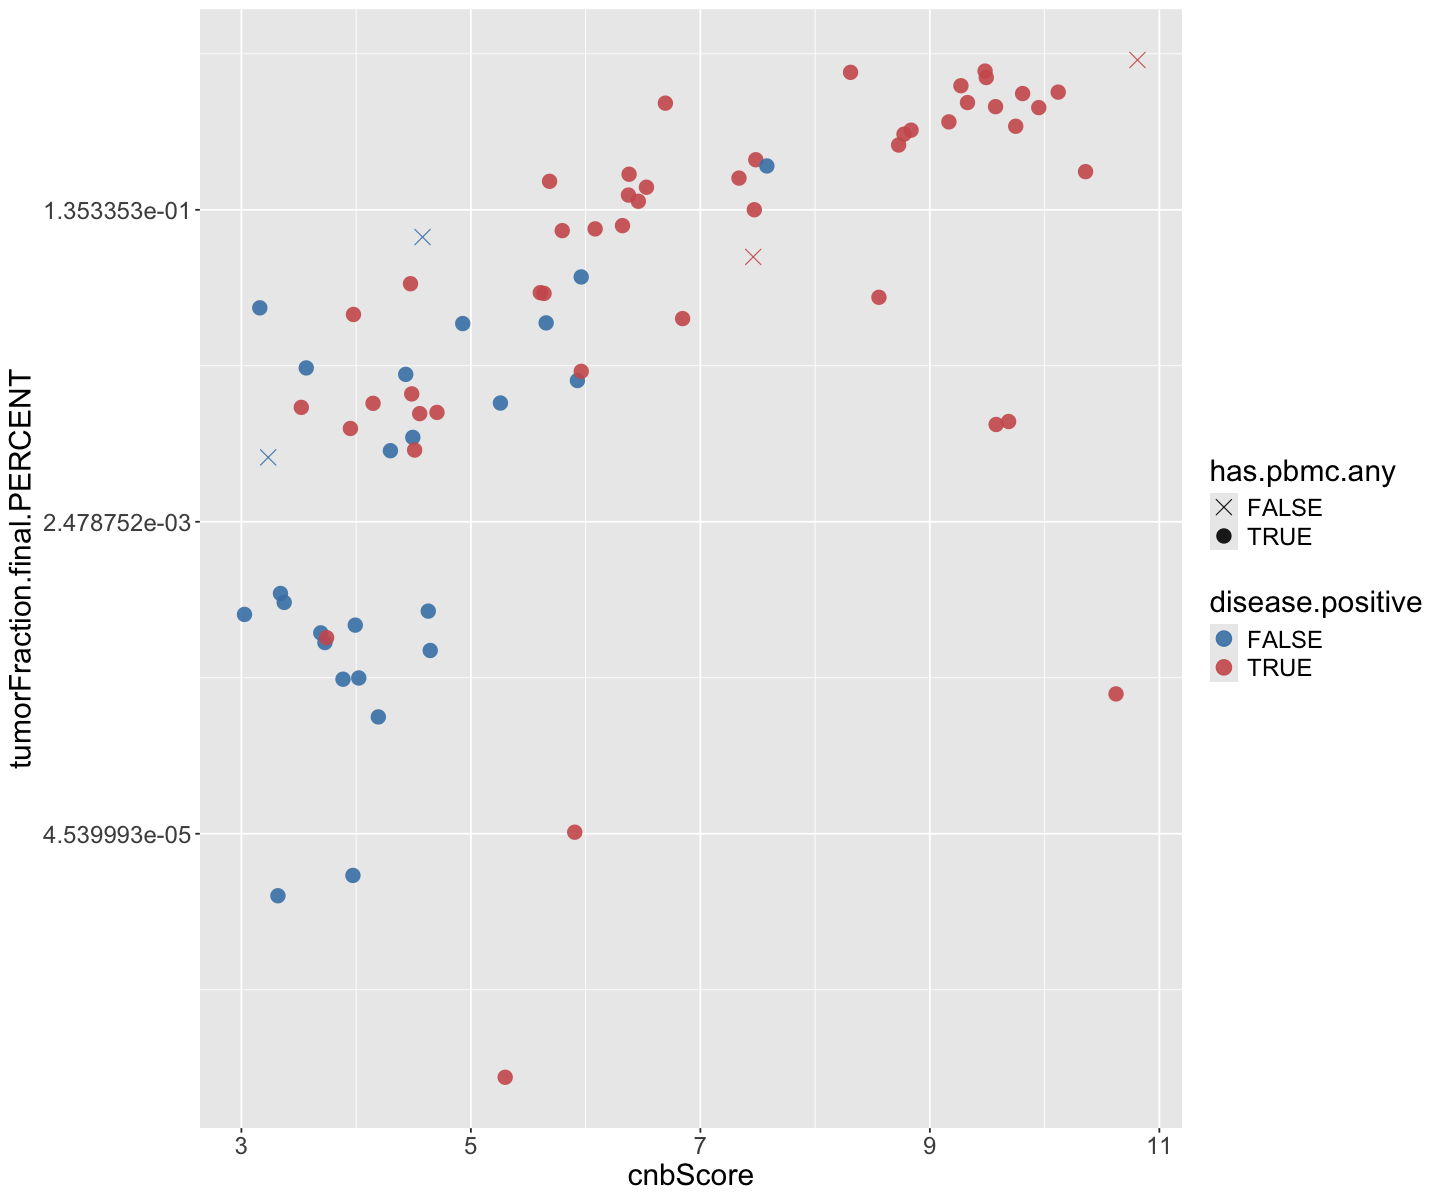

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”


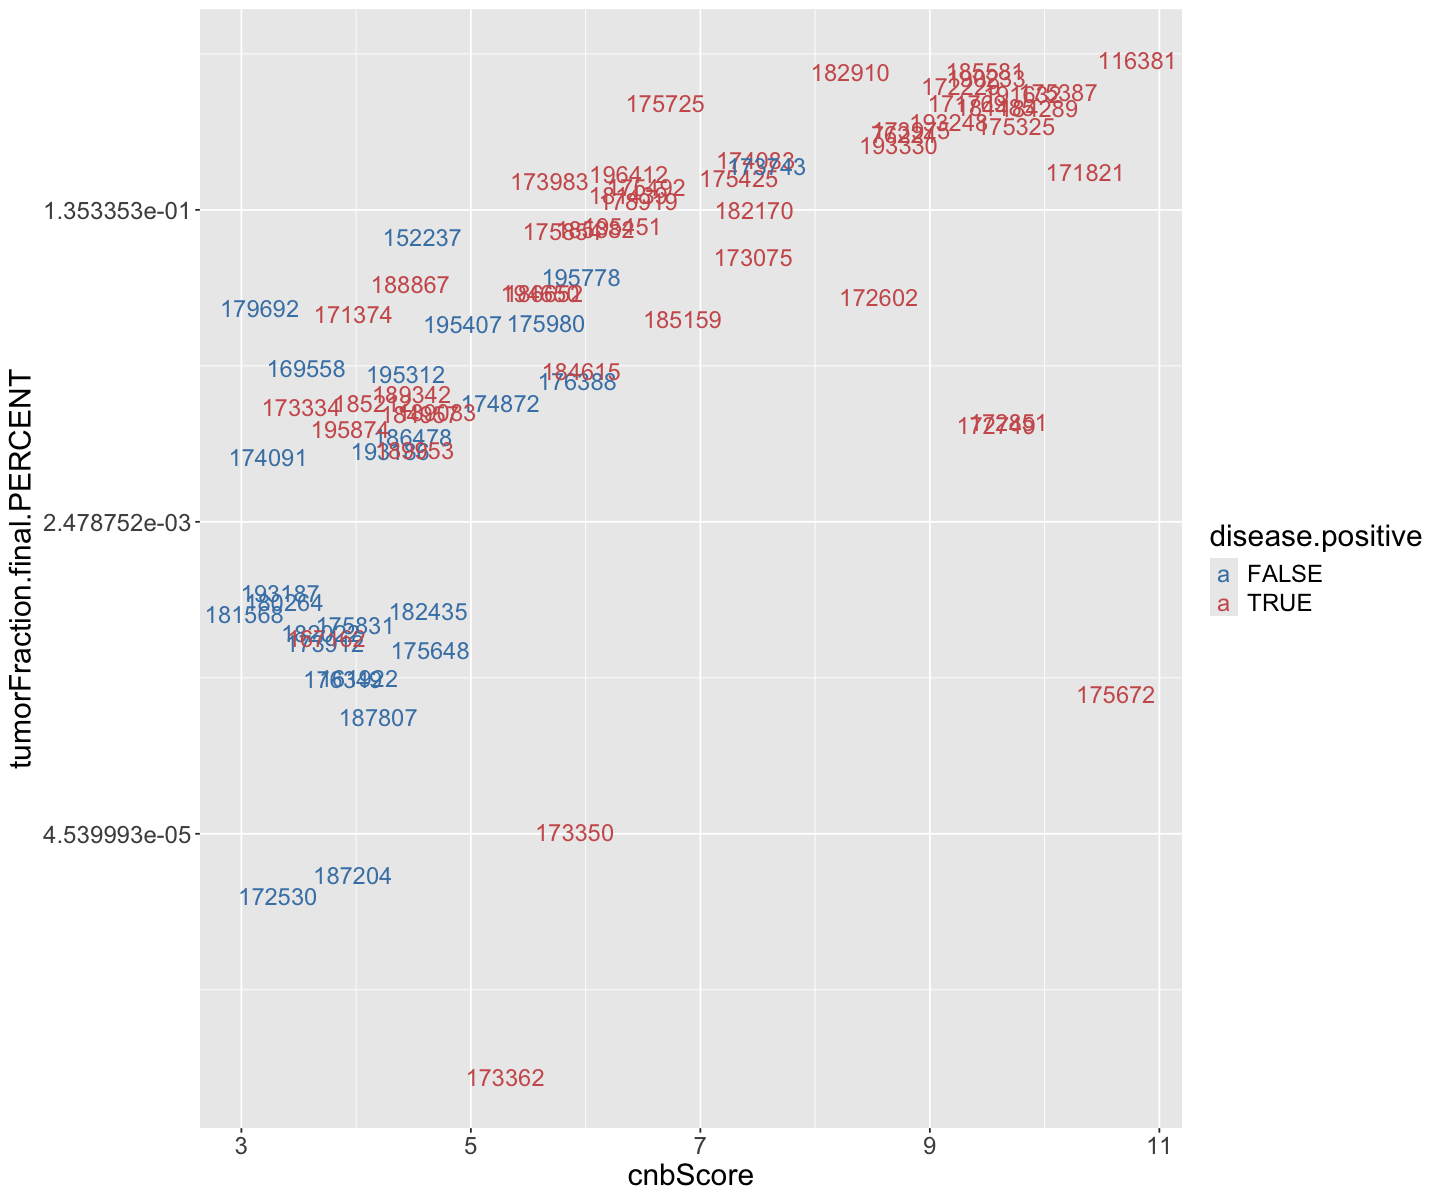

Warning message:
“Removed 18 rows containing missing values or values outside the scale range (`geom_point()`).”


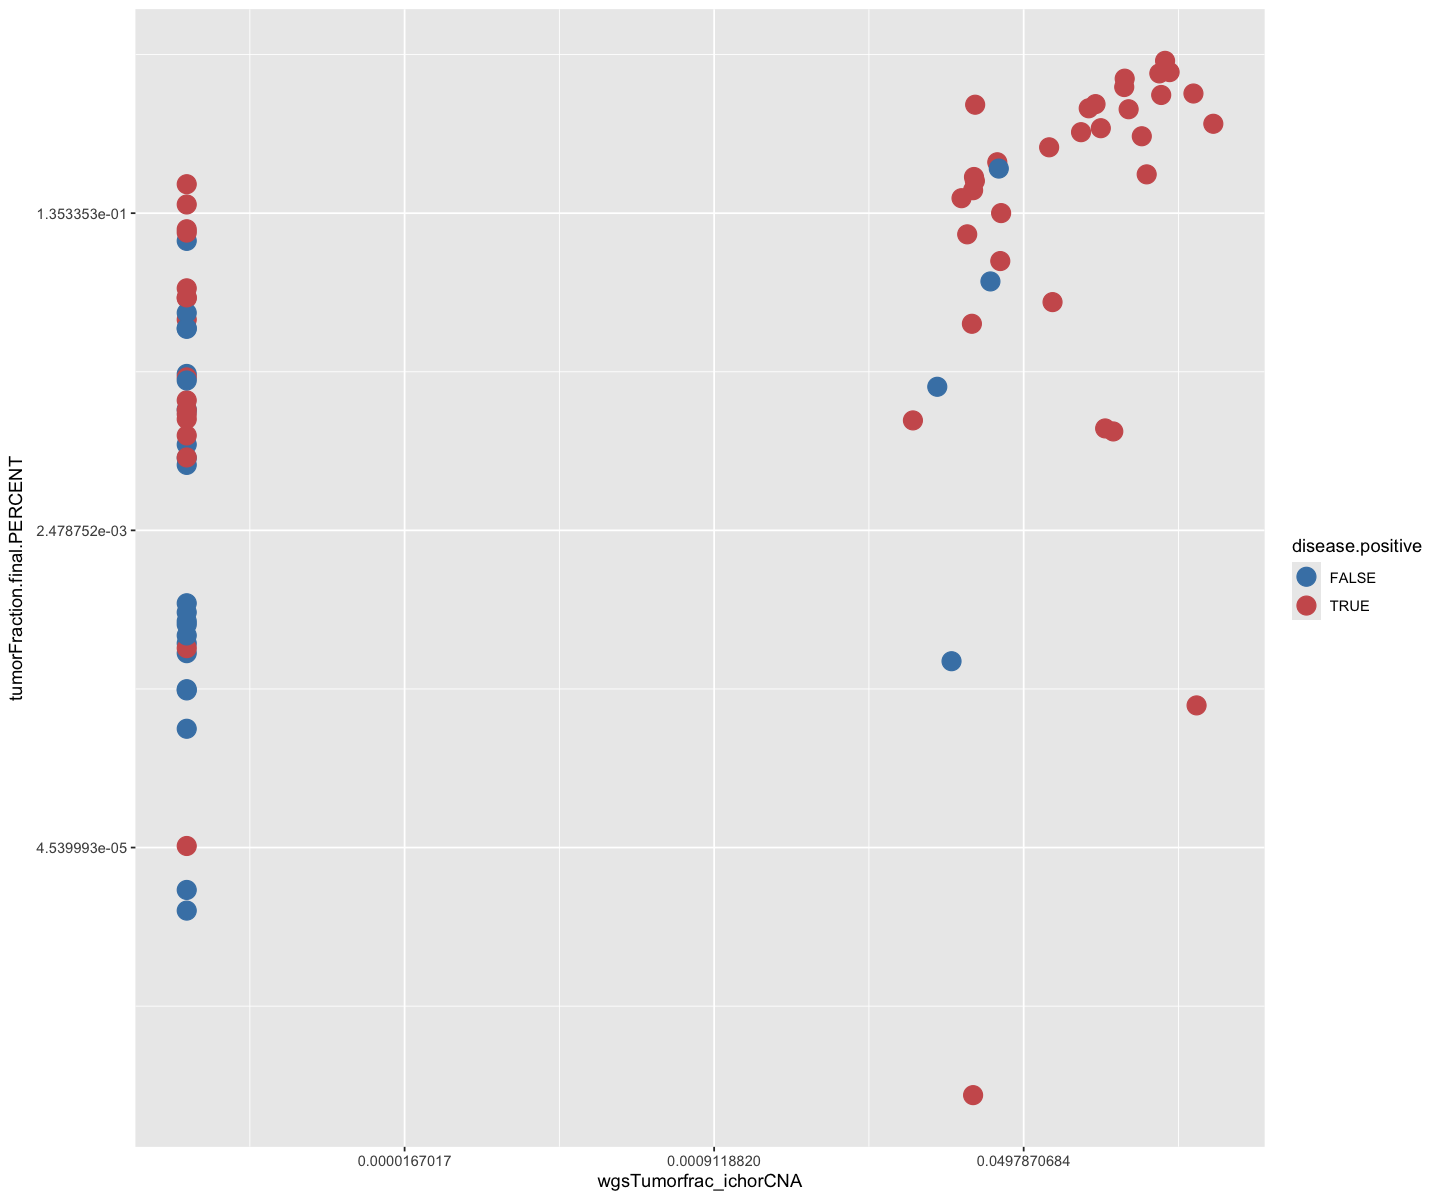

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”


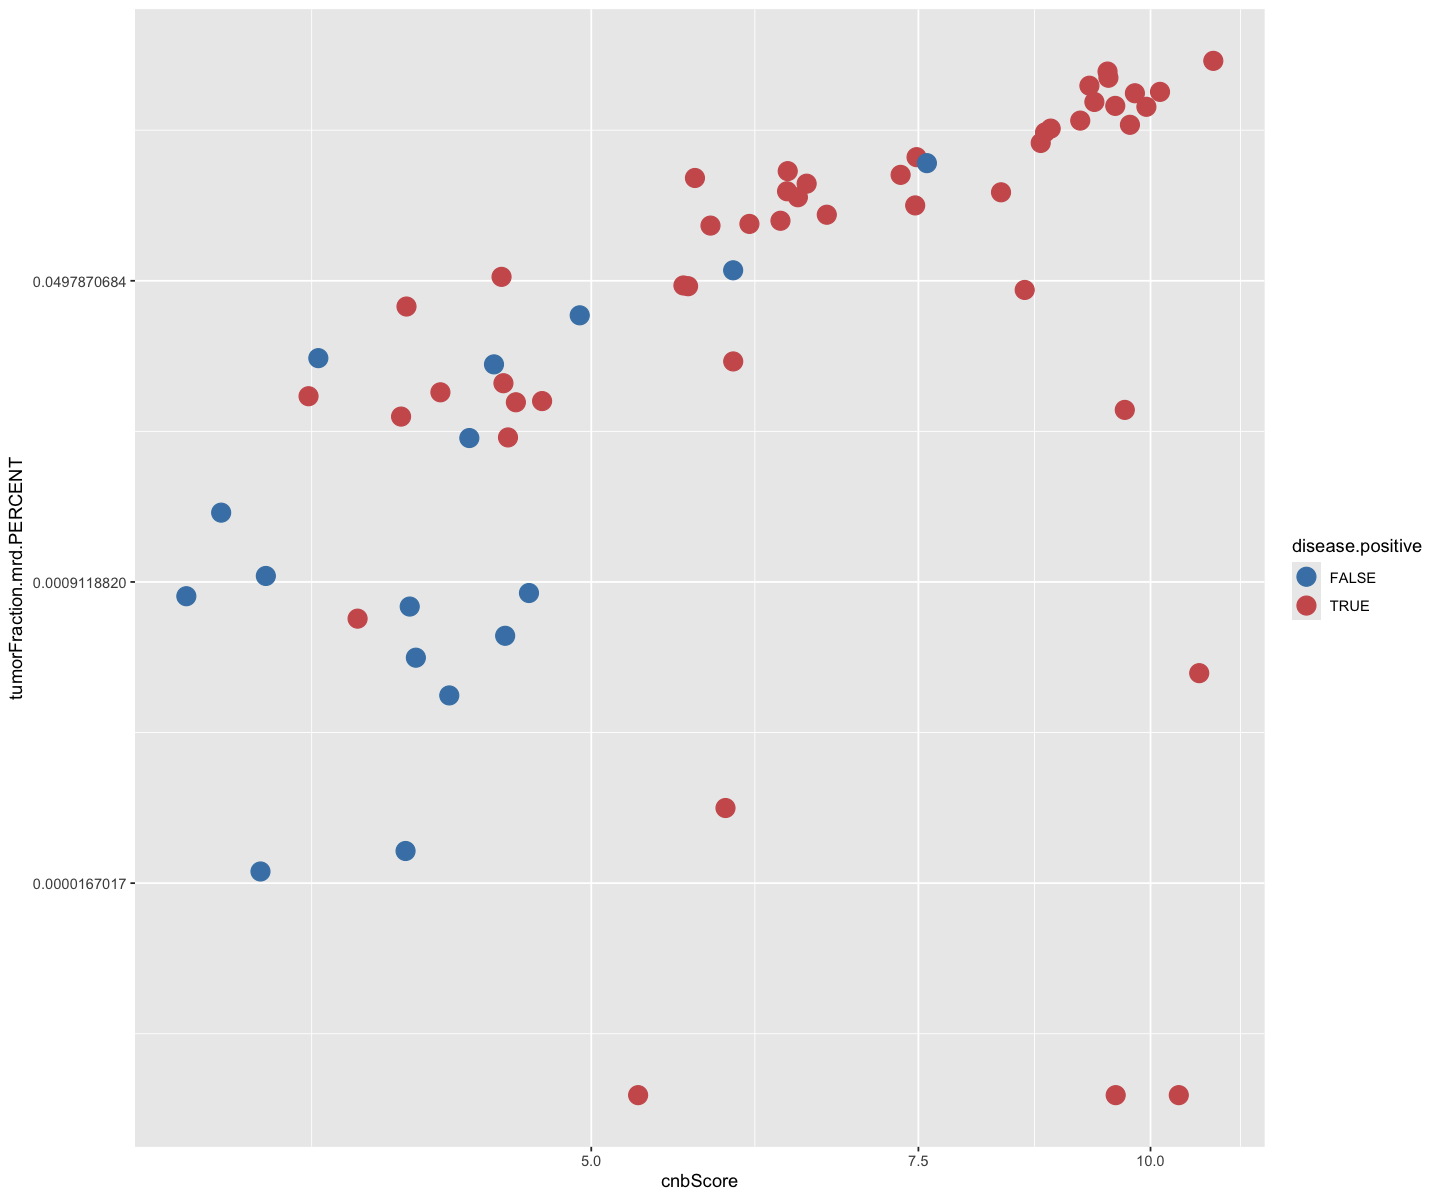

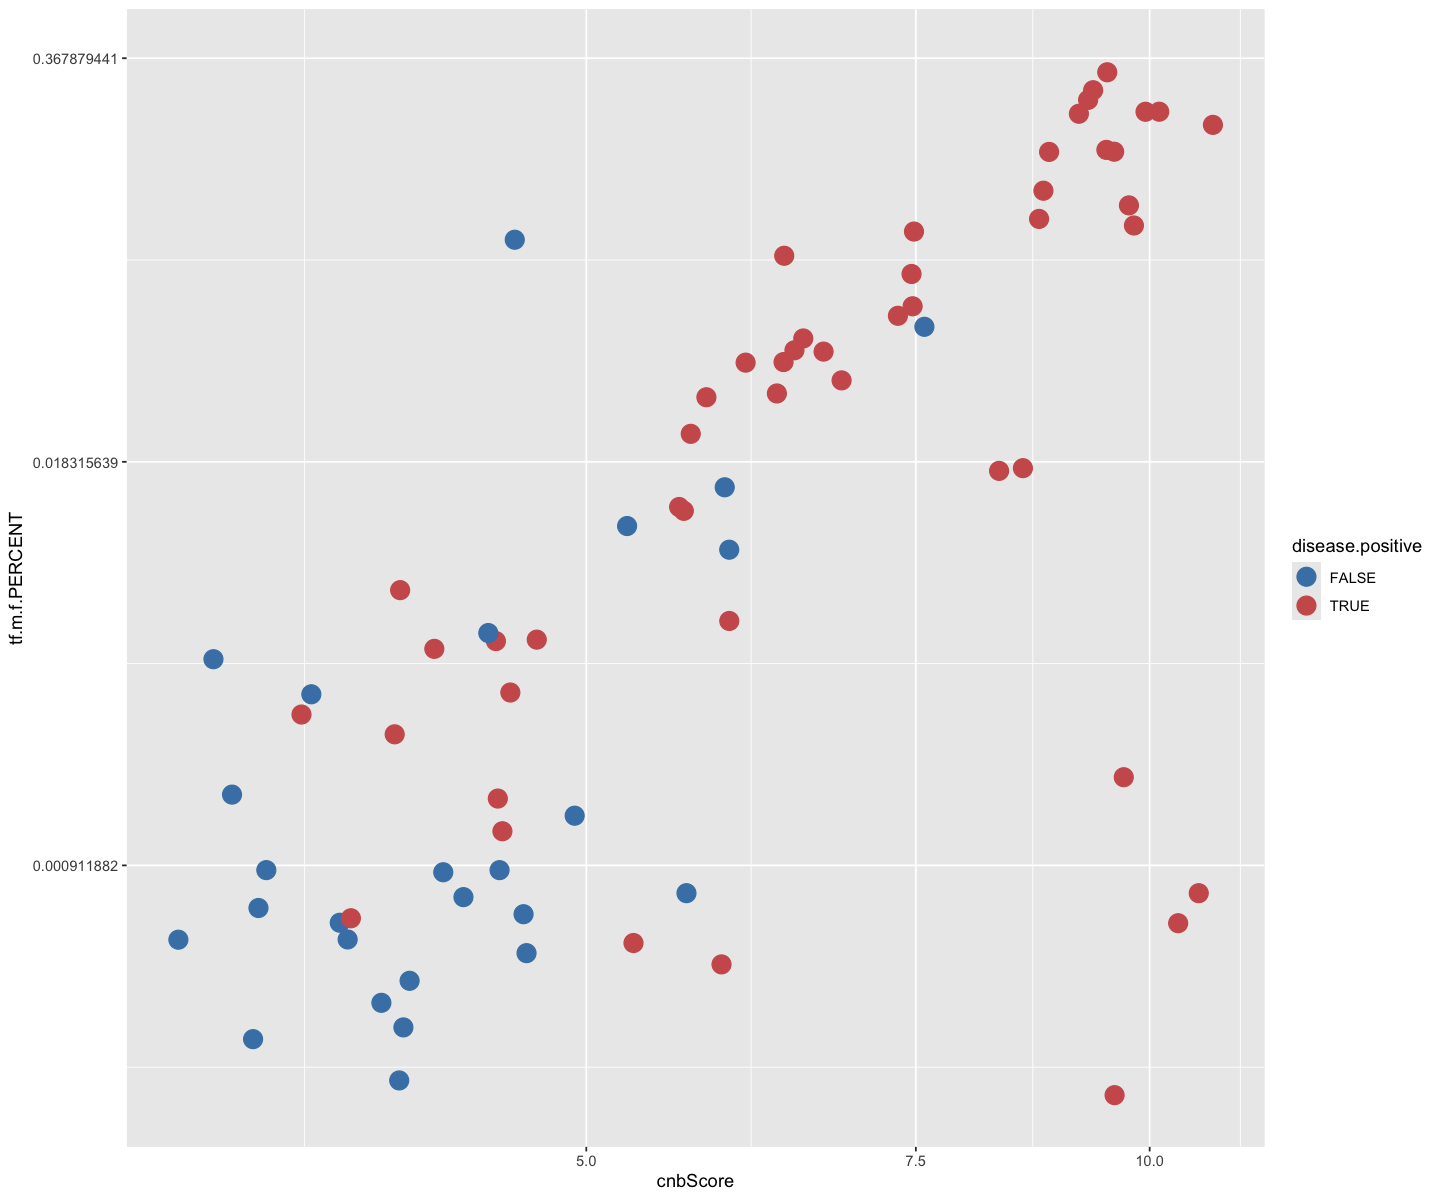

In [45]:
# correlations between tumor fraciton estimates
# 3 patients don't have a lpwgs value
options(repr.plot.width=12, repr.plot.height=10)

# for plotting
df.mrd.ind.pre.plt = df.mrd.preur %>% mutate(tumorFraction.final.PERCENT = tumorFraction.final.PERCENT + 0.000001,
                                             tumorFraction.pipeline.PERCENT = tumorFraction.pipeline.PERCENT + 0.000001,
                                               tumorFraction.mrd.PERCENT = tumorFraction.mrd.PERCENT + 0.000001,
                                               tf.m.f.PERCENT = tf.m.f.PERCENT + 0.000001,
                                              wgsTumorfrac_ichorCNA = wgsTumorfrac_ichorCNA + 0.000001,
                                              tumorFraction.final.PERCENT = tumorFraction.final.PERCENT + 0.000001,)

jpeg(glue("Manuscript/plots/NMIBC_tumorFraction_vs_cnbScore_scatter_{Sys.Date()}.jpg"), width=12, height=10, units="in", res=300)
gg <- ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.pbmc.any)) +
    geom_point(size=4, alpha=0.9) +
    scale_color_manual(breaks=c("FALSE","TRUE"),values =c("steelblue","indianred")) +
    scale_shape_manual(breaks=c("FALSE","TRUE"), values = c(4,16)) + 
    scale_y_continuous(transform = "log") + 
    theme(text=element_text(size=18))
show(gg)
dev.off()
show(gg)

jpeg(glue("Manuscript/plots/NMIBC_tumorFraction_vs_cnbScore_scatter_PatientID_{Sys.Date()}.jpg"), width=12, height=10, units="in", res=300)
gg <- ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, 
                                     color=disease.positive, label=PatientID)) +
    #geom_point(size=7) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    scale_color_manual(breaks=c("FALSE","TRUE"),values =c("steelblue","indianred")) +
    scale_y_continuous(transform = "log") + 
    theme(text=element_text(size=18))
show(gg)
dev.off()
show(gg)

## supplemental plots
# one additional true negative call gained by imposing secondary wgsTF threshold for positive patients

ggplot(df.mrd.ind.pre.plt, aes(x=wgsTumorfrac_ichorCNA, y=tumorFraction.final.PERCENT, color=disease.positive)) +
    geom_point(size=5) +
    scale_color_manual(breaks=c("FALSE","TRUE"),values =c("steelblue","indianred")) +
    scale_y_continuous(transform = "log") + 
    scale_x_continuous(transform = "log")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.mrd.PERCENT, color=disease.positive)) +
    geom_point(size=5) +
    scale_color_manual(breaks=c("FALSE","TRUE"),values =c("steelblue","indianred")) +
    scale_y_continuous(transform = "log") + 
    scale_x_continuous(transform = "log")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tf.m.f.PERCENT, color=disease.positive)) +
    geom_point(size=5) +
    scale_color_manual(breaks=c("FALSE","TRUE"),values =c("steelblue","indianred")) +
    scale_y_continuous(transform = "log") + 
    scale_x_continuous(transform = "log")

In [47]:
## disease prediction AUCs  # try subset of NMIBC genes only for calling

pdf(glue("Manuscript/plots/ROC_curves_{Sys.Date()}.pdf"), onefile = TRUE)
get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "tumorFraction.final.PERCENT",title = "tumorFraction.final.PERCENT")

get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "cnbScore",title = "cnbScore")

get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "wgsTumorfrac_ichorCNA",title = "wgsTumorfrac_ichorCNA")

get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "tumorFraction.pipeline.PERCENT",title = "tumorFraction.pipeline.PERCENT")

get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "tumorFraction.mrd.PERCENT",title = "tumorFraction.mrd.PERCENT")

get_sens_spec(df = df.mrd.preur, label_col = "disease.positive.bin", 
              score_col = "tf.m.f.PERCENT",title = "tf.m.f.PERCENT")
dev.off()


   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



   threshold specificity sensitivity
1 0.03264895   0.8518519   0.7222222
2 0.04129500   0.8888889   0.6851852
[1] "AUC: 0.836762688614541"

   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



  threshold specificity sensitivity
1  5.278126   0.8461538   0.7959184
[1] "AUC: 0.87519623233909"

   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



  threshold specificity sensitivity
1   0.02095   0.9230769   0.6326531
[1] "AUC: 0.783359497645212"

   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



  threshold specificity sensitivity
1  0.041295   0.8947368   0.6923077
[1] "AUC: 0.82995951417004"

   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



   threshold specificity sensitivity
1 0.00619091   0.7058824   0.8653846
[1] "AUC: 0.809954751131222"

   0    1 <NA> 
  27   54    0 


Setting levels: control = 0, case = 1



    threshold specificity sensitivity
1 0.001648804   0.7037037   0.8518519
2 0.016138437   0.9259259   0.6296296
[1] "AUC: 0.837448559670782"


pdf 
  2

          
           FALSE TRUE <NA>
  highRisk     3   34    0
  lowRisk     23   15    0
  <NA>         0    0    0

	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 1.789e-06
alternative hypothesis: two.sided

       
        FALSE TRUE <NA>
  FALSE     4    6    0
  TRUE     23   48    0
  <NA>      0    0    0

	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 0.7242
alternative hypothesis: two.sided



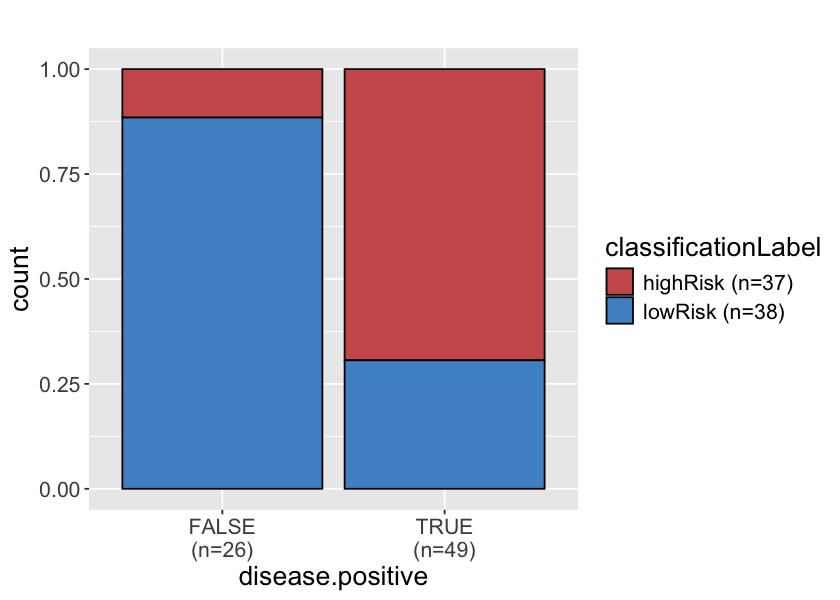

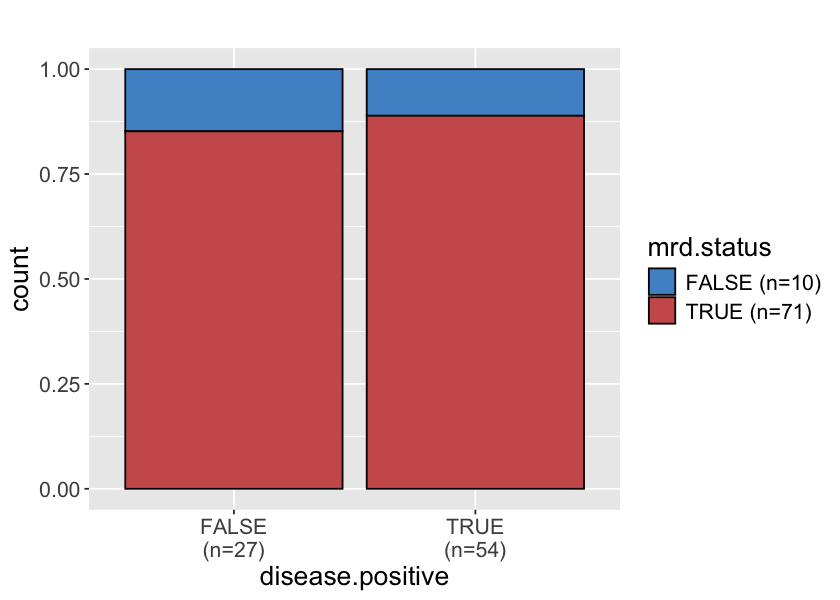

In [51]:
## correlation of pipeline calls with disease positivity - LPWGS p<0.0001, BEACON - NS
source("~/Desktop/puffin/R/helper_functions.R")
options(repr.plot.width=7, repr.plot.height=5)

contingency_plot(df = df.mrd.preur %>% filter(!is.na(classificationLabel)), 
                 x = "disease.positive", y = "classificationLabel", 
                 y.percent = FALSE, colors = c("lowRisk"="steelblue3", "highRisk"="indianred"))

contingency_plot(df = df.mrd.all.internal %>% filter(SampleID.short.sample %in% df.mrd.preur$SampleID.short.sample,
                                                     StudyVisit.baseline == "IndexTURBT",
                                                    !is.na(mrd.status)),
                x = "disease.positive", y = "mrd.status", 
                y.percent = FALSE, colors = c("FALSE"="steelblue3", "TRUE"="indianred"))

In [52]:
# boxplots - exploratory
source("~/Desktop/Predicine/helper_functions.R")

pdf(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplots_{Sys.Date()}.pdf"), onefile = TRUE)

options(repr.plot.width=7, repr.plot.height=7)
for (stat in c('tumorFraction.final.PERCENT','tumorFraction.pipeline.PERCENT','tf.m.f.PERCENT','tumorFraction.mrd.PERCENT',
                'mutationCount','mutationCount.mrd','mutationCount.mrd.f')){   
    
    g <- quick_boxplot(df.mrd.preur, x="disease.positive",y=stat, 
                       colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, log.0.adj=0.000001, plot.title = glue("{stat} recurence prediction")
                       #label.col="PatientID"
                      )
    show(g)
}

for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM')){
    g <- quick_boxplot(df.mrd.preur, x="disease.positive",y=stat, 
                       colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} recurence prediction")
                       #pt.label="PatientID"
                      )
    show(g)
}
dev.off()
                                                                         

Complete cases tumorFraction.final.PERCENT by disease.positive: 81
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    27 FALSE (n=27)    blue
TRUE              TRUE    54  TRUE (n=54) darkred


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


FALSE median: 0.00098658
TRUE median: 0.15724

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 238, p-value = 8.919e-07
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases tumorFraction.pipeline.PERCENT by disease.positive: 71
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    19 FALSE (n=19)    blue
TRUE              TRUE    52  TRUE (n=52) darkred
FALSE median: 0.00565770862800566
TRUE median: 0.17215

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 168, p-value = 2.362e-05
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases tf.m.f.PERCENT by disease.positive: 81
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    27 FALSE (n=27)    blue
TRUE              TRUE    54  TRUE (n=54) darkred
FALSE median: 0.000740740740740741
TRUE median: 0.0383581025

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 237, p-value = 8.474e-07
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases tumorFraction.mrd.PERCENT by disease.positive: 69
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    17 FALSE (n=17)    blue
TRUE              TRUE    52  TRUE (n=52) darkred
FALSE median: 0.000786367
TRUE median: 0.127586282398105

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 168, p-value = 0.0001396
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases mutationCount by disease.positive: 81
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    27 FALSE (n=27)    blue
TRUE              TRUE    54  TRUE (n=54) darkred
FALSE median: 32
TRUE median: 25

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 943, p-value = 0.03237
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases mutationCount.mrd by disease.positive: 81
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    27 FALSE (n=27)    blue
TRUE              TRUE    54  TRUE (n=54) darkred
FALSE median: 25
TRUE median: 17

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 889, p-value = 0.1098
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases mutationCount.mrd.f by disease.positive: 81
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    27 FALSE (n=27)    blue
TRUE              TRUE    54  TRUE (n=54) darkred
FALSE median: 21
TRUE median: 14.5

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 769, p-value = 0.6921
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases wgsTumorfrac_ichorCNA by disease.positive: 75
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    26 FALSE (n=26)    blue
TRUE              TRUE    49  TRUE (n=49) darkred
FALSE median: 0
TRUE median: 0.0265

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 276, p-value = 1.497e-05
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases cnbScore by disease.positive: 75
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    26 FALSE (n=26)    blue
TRUE              TRUE    49  TRUE (n=49) darkred
FALSE median: 4.10806756687142
TRUE median: 6.84507032181515

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 159, p-value = 1.062e-07
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


Complete cases wgsTumorfrac_EM by disease.positive: 75
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    26 FALSE (n=26)    blue
TRUE              TRUE    49  TRUE (n=49) darkred
FALSE median: 0
TRUE median: 0.070487704

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 238.5, p-value = 1.062e-06
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

In [61]:
## MS Boxplots
# two key metrics, cnbScore and panel TF

df.mrd.preur.sel <- df.mrd.preur %>% filter(!is.na(tumorFraction.final.PERCENT) & !is.na(cnbScore))

# PANEL TF
jpeg(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplot_PanelTF_{Sys.Date()}.jpg"), res=300, width=10, height=10, units = "in")
quick_boxplot(df.mrd.preur.sel, x="disease.positive",y="tumorFraction.final.PERCENT", 
                       colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, log.0.adj=0.000001
                       #label.col="PatientID"
                      )
dev.off()
jpeg(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplot_PanelTF_ROC_{Sys.Date()}.jpg"), res=300, width=10, height=10, units = "in")
get_sens_spec(df = df.mrd.preur.sel, label_col = "disease.positive.bin", 
              score_col = "tumorFraction.final.PERCENT",title = "tumorFraction.final.PERCENT")
dev.off()

## CNB SCORE
jpeg(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplot_cnbScore_{Sys.Date()}.jpg"), res=300, width=10, height=10, units = "in")
quick_boxplot(df.mrd.preur.sel, x="disease.positive",y="cnbScore", 
                       colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE
                       #label.col="PatientID"
                      )
dev.off()
jpeg(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplot_cnbScore_ROC_{Sys.Date()}.jpg"), res=300, width=10, height=10, units = "in")
get_sens_spec(df = df.mrd.preur.sel, label_col = "disease.positive.bin", 
              score_col = "cnbScore",title = "cnbScore")
dev.off()


Complete cases tumorFraction.final.PERCENT by disease.positive: 75
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    26 FALSE (n=26)    blue
TRUE              TRUE    49  TRUE (n=49) darkred
FALSE median: 0.00332214431400283
TRUE median: 0.13547

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 222, p-value = 3.941e-06
alternative hypothesis: true location shift is not equal to 0

for plotting log.0.adj=1e-06


Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2


   0    1 <NA> 
  26   49    0 


Setting levels: control = 0, case = 1



   threshold specificity sensitivity
1 0.03264895   0.8461538   0.7142857
[1] "AUC: 0.82574568288854"


pdf 
  2

Complete cases cnbScore by disease.positive: 75
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    26 FALSE (n=26)    blue
TRUE              TRUE    49  TRUE (n=49) darkred
FALSE median: 4.10806756687142
TRUE median: 6.84507032181515

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 159, p-value = 1.062e-07
alternative hypothesis: true location shift is not equal to 0



Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2


   0    1 <NA> 
  26   49    0 


Setting levels: control = 0, case = 1



  threshold specificity sensitivity
1  5.278126   0.8461538   0.7959184
[1] "AUC: 0.87519623233909"


pdf 
  2

In [56]:
######### boxplots as a plot GRID
source("~/Desktop/Predicine/helper_functions.R")
pdf(glue("./Manuscript/plots/NMIBC_preUR_disease_prediction_boxplots_GRID_{Sys.Date()}.pdf"), 
    width=14, height=7, onefile = TRUE)

## Panel
df.mrd.ind.pre.long <- df.mrd.preur %>% 
        pivot_longer(cols = c('tumorFraction.final.PERCENT','tumorFraction.pipeline.PERCENT','tf.m.f.PERCENT','tumorFraction.mrd.PERCENT'),
                    names_to="data_type",  values_to="tumor.fraction.percent", values_drop_na = TRUE) %>%
        mutate("data_type"=factor(data_type)) %>%
        select(PatientID, SampleID.short.sample, data_type, tumor.fraction.percent, disease.positive)

g <- quick_boxplot(df.mrd.ind.pre.long, x="disease.positive",y="tumor.fraction.percent", 
                   colors=c("FALSE"="blue","TRUE"="darkred"), facet = "data_type",
                   log.axes = TRUE, log.0.adj=0.000001, plot.title = "PreUR/UCP MRD")   
show(g)

## WGS
df.mrd.ind.pre.long <- df.mrd.preur %>% 
        pivot_longer(cols = c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM'),
                    names_to="data_type",  values_to="tumor.fraction.or.score", values_drop_na = TRUE) %>%
        mutate("data_type"=factor(data_type)) %>%
        select(PatientID, SampleID.short.sample, data_type, tumor.fraction.or.score, disease.positive)

g <- quick_boxplot(df.mrd.ind.pre.long, x="disease.positive",y="tumor.fraction.or.score", 
                   colors=c("FALSE"="blue","TRUE"="darkred"), facet = "data_type",
                   log.axes = TRUE, log.0.adj=0.000001, plot.title = "PreUR/UCP MRD")
show(g)

dev.off()


Complete cases tumor.fraction.percent by disease.positive: 302
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    90 FALSE (n=90)    blue
TRUE              TRUE   212 TRUE (n=212) darkred
# A tibble: 81 × 4
   disease.positive tumor.fraction.percent data_type      label
   <fct>                             <dbl> <fct>          <chr>
 1 TRUE                           0.0225   tf.m.f.PERCENT ""   
 2 TRUE                           0.00280  tf.m.f.PERCENT ""   
 3 FALSE                          0.000250 tf.m.f.PERCENT ""   
 4 TRUE                           0.0175   tf.m.f.PERCENT ""   
 5 FALSE                          0.00325  tf.m.f.PERCENT ""   
 6 TRUE                           0.00176  tf.m.f.PERCENT ""   
 7 TRUE                           0.000511 tf.m.f.PERCENT ""   
 8 FALSE                          0.000386 tf.m.f.PERCENT ""   
 9 TRUE                           0.270    tf.m.f.PERCENT ""   
10 TRUE                           0.290    t

Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_text()`).”


Complete cases tumor.fraction.or.score by disease.positive: 225
[1] "FALSE" "TRUE" 
      disease.positive count       legend   color
FALSE            FALSE    78 FALSE (n=78)    blue
TRUE              TRUE   147 TRUE (n=147) darkred
# A tibble: 75 × 4
   disease.positive tumor.fraction.or.score data_type label
   <fct>                              <dbl> <fct>     <chr>
 1 TRUE                                5.69 cnbScore  ""   
 2 TRUE                                3.52 cnbScore  ""   
 3 FALSE                               3.32 cnbScore  ""   
 4 TRUE                                8.56 cnbScore  ""   
 5 FALSE                               3.56 cnbScore  ""   
 6 TRUE                                9.69 cnbScore  ""   
 7 TRUE                                5.30 cnbScore  ""   
 8 FALSE                               4.02 cnbScore  ""   
 9 TRUE                                9.27 cnbScore  ""   
10 TRUE                                9.33 cnbScore  ""   
# ℹ 65 more rows
FALSE medi

Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 81 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

## multivariate models

In [82]:
library(caret)
library(themis) # for smote I think
library(rattle)

packageVersion("caret")

Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:ComplexHeatmap’:

    prepare


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




[1] ‘6.0.94’

In [69]:
## working example
# stepwise (aka simple decision tree)
# https://rpubs.com/maulikpatel/229337 - old 2016

# data("iris")
# names(iris) = tolower(names(iris))
# head(iris)
# table(iris$species)

# index = createDataPartition(y=iris$species, p=0.7, list=TRUE)
# head(index)
# index = index$Resample1
# train.set = iris[index,]
# test.set = iris[-index,]
# dim(train.set)

# with(iris, qplot(petal.width, sepal.width, colour=species, cex=2))

# # fit the model
# iris.tree = train(species ~ ., 
#                   data=train.set, 
#                   method="rpart", 
#                   trControl = trainControl(method = "cv"))

# iris.tree

# # plot the model
# plot(iris.tree$finalModel, uniform=TRUE,
#      main="Classification Tree")

# text(iris.tree$finalModel, use.n.=TRUE, all=TRUE, cex=.8)

# fancyRpartPlot(iris.tree$finalModel)

## prediction
# iris.pred = predict(iris.tree, newdata = test.set)
# table(iris.pred, test.set$species)

# error.rate = round(mean(iris.pred != test.set$species),2)
# error.rate

In [192]:
# load data
df.mrd.preur = read.csv("data_delivery/cohort_summary_Extended_2024-06-03.csv", as.is=T) %>%
    filter(!is.na(SampleType.sample),
           has.preUR.Panel.TF & has.preUR.LPWGS.TF) %>% # use only samples with both TF values
    mutate(PatientID = as.character(PatientID)) %>%
    rename("has.pbmc.wes"="has.pbmc")
nrow(df.mrd.preur)
df.mrd.preur = df.mrd.preur %>% mutate(across(all_of(c("tumorFraction.pipeline.PERCENT",
                                                       "tumorFraction.mrd.PERCENT",
                                                       "tf.m.f.PERCENT","mutationCount",
                                                       "tumorFraction.final.PERCENT",
                                                       "cnbScore")), as.numeric),
                                      has.pbmc.any = !is.na(germline.seq.method) & !(germline.seq.method=="WES+" & has.pbmc.wes=="FALSE"),
                                      disease.positive = factor(ifelse(disease.positive=="FALSE","Non.Recur","Recurring")),
                                      )
table(df.mrd.preur$disease.positive)
table(df.mrd.preur$PatientID.sample, df.mrd.preur$StudyVisit.baseline)
sort(names(df.mrd.preur))


[1] 75


Non.Recur Recurring      <NA> 
       26        49         0 

        
         IndexTURBT <NA>
  76224           1    0
  116381          1    0
  152237          1    0
  161922          1    0
  167162          1    0
  169558          1    0
  171374          1    0
  171769          1    0
  171821          1    0
  172229          1    0
  172530          1    0
  172602          1    0
  172749          1    0
  172851          1    0
  173075          1    0
  173334          1    0
  173350          1    0
  173362          1    0
  173743          1    0
  173912          1    0
  173975          1    0
  173983          1    0
  174083          1    0
  174091          1    0
  174872          1    0
  175325          1    0
  175387          1    0
  175425          1    0
  175492          1    0
  175648          1    0
  175672          1    0
  175725          1    0
  175831          1    0
  175854          1    0
  175980          1    0
  176349          1    0
  176388          1    0
  178919          1    0
  179692        

[1] "Age"                                                                                                            
  [2] "any_progression"                                                                                                
  [3] "armAbnormalityScore"                                                                                            
  [4] "Baseline"                                                                                                       
  [5] "benign"                                                                                                         
  [6] "checkDynamic"                                                                                                   
  [7] "classificationLabel"                                                                                            
  [8] "Clinical.Recurrence."                                                                                           
  [9] "cnbScore"                                                                                                       
 [10] "Cohort"                                                                                                         
 [11] "Complete."                                                                                                      
 [12] "CytoscopyDate"                                                                                                  
 [13] "Date.of.Subsequent.TURBT"                                                                                       
 [14] "disease.positive"                                                                                               
 [15] "disease.positive.bin"                                                                                           
 [16] "ECOG.scoreAt.Repeat.TURBT"                                                                                      
 [17] "excludeCount"                                                                                                   
 [18] "externalSampleID"                                                                                               
 [19] "externalTrialVisitNum"                                                                                          
 [20] "fc.tf.ext.f"                                                                                                    
 [21] "fc.tf.f"                                                                                                        
 [22] "fc.tf.m.f"                                                                                                      
 [23] "fragmentNum"                                                                                                    
 [24] "germline.seq.method"                                                                                            
 [25] "group1.index_repeat_paired"                                                                                     
 [26] "group2.index_urine_paired"                                                                                      
 [27] "group3.index_repeat_urine_trio"                                                                                 
 [28] "has.Index.wes"                                                                                                  
 [29] "has.IndexTURBT"                                                                                                 
 [30] "has.pbmc.any"                                                                                                   
 [31] "has.pbmc.wes"                                                                                                   
 [32] "has.preUR.LPWGS.TF"                                                                                             
 [33] "has.preUR.methyl.data"                                                                                          
 [34] "has.preUR.Panel.TF"                

In [212]:
# # fit the model with 5X100 CV
set.seed(4)
#getModelInfo(model = "rpartScore")
#getModelInfo(model = "rpart2")

n.folds = 5
n.iter = 100
fitControl <- trainControl(method = "repeatedcv",
                           number = n.folds, # number of folds for each iteration
                           repeats = n.iter, # num iterations
                           # preProcOptions = # no pre=processing
                           verboseIter=FALSE,
                           returnData=TRUE,
                           savePredictions = "all",
                           returnResamp = "all", 
                           classProbs=TRUE, 
                           summaryFunction = twoClassSummary, 
                           sampling="smote", # for class imbalance  ### impute missing data for ~6 samples?
                           selectionFunction = "best") # "oneSE", see methods, but both have same curve output here https://topepo.github.io/caret/model-training-and-tuning.html 

model.fit = train(disease.positive ~ cnbScore + tumorFraction.final.PERCENT,
                  data= df.mrd.preur, 
                  method="rpart2", tuneGrid = data.frame("maxdepth"=2), # one param. use a tree with two splits only (=one for each variable?)
                  trControl = fitControl,
                  metric = "ROC", maximize=TRUE, # todo: try sensitivity here
                  )

model.fit
# resampling results here may be averages across folds . . don't match output of plotROC function for best model

CART 

75 samples
 2 predictor
 2 classes: 'Non.Recur', 'Recurring' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 100 times) 
Summary of sample sizes: 60, 59, 60, 60, 61, 59, ... 
Addtional sampling using SMOTE

Resampling results:

  ROC        Sens       Spec     
  0.7673481  0.8245333  0.6977333

Tuning parameter 'maxdepth' was held constant at a value of 2

Warning message in text.default(xy$x, xy$y + 0.5 * cxy[2L], rows[left.child], ...):
“"use.n." is not a graphical parameter”
Warning message in text.default(xy$x[leaves], xy$y[leaves] - 0.5 * cxy[2L], stat, :
“"use.n." is not a graphical parameter”


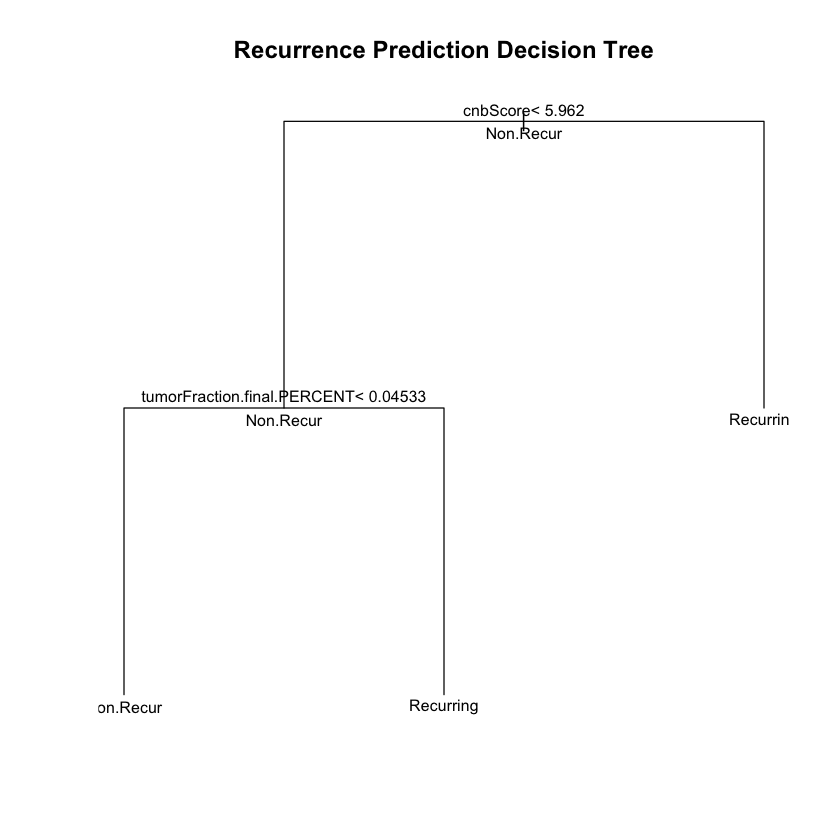

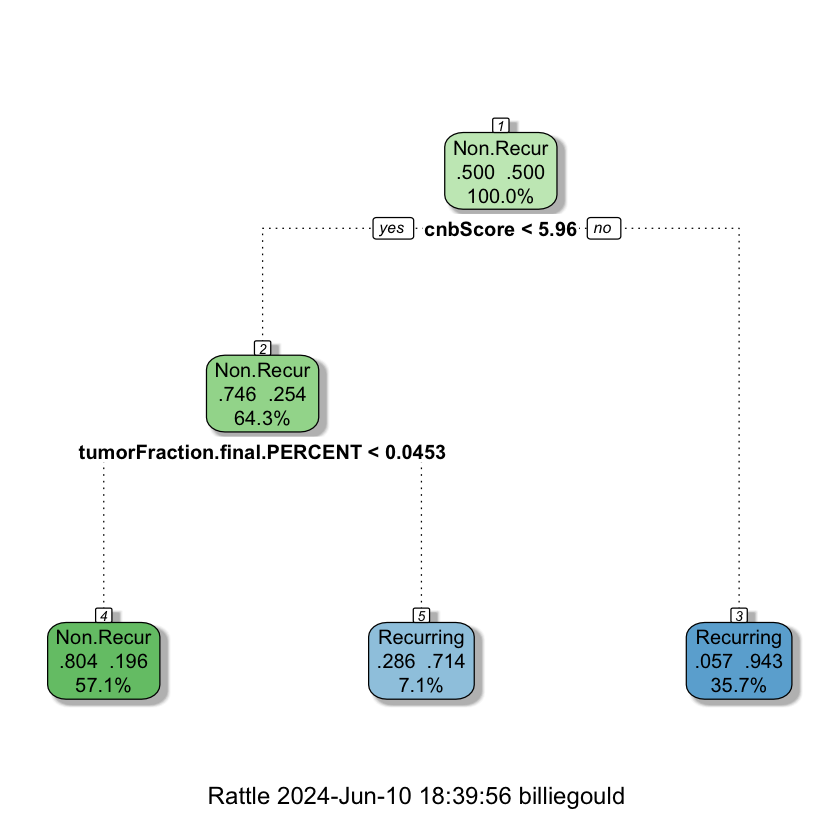

In [213]:
# plot the model tree
plot(model.fit$finalModel, uniform=TRUE,
     main="Recurrence Prediction Decision Tree")

# exact numbers
text(model.fit$finalModel, use.n.=TRUE, all=TRUE, cex=.8)

# nice chart - many customizable params under the wrapper: https://www.rdocumentation.org/packages/rpart.plot/versions/3.1.2/topics/prp
fancyRpartPlot(model.fit$finalModel,digits=3)

n= 98 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 98 49 Non.Recur (0.50000000 0.50000000)  
  2) cnbScore< 5.96152 63 16 Non.Recur (0.74603175 0.25396825)  
    4) tumorFraction.final.PERCENT< 0.04532877 56 11 Non.Recur (0.80357143 0.19642857) *
    5) tumorFraction.final.PERCENT>=0.04532877 7  2 Recurring (0.28571429 0.71428571) *
  3) cnbScore>=5.96152 35  2 Recurring (0.05714286 0.94285714) *

,pred,obs,Non.Recur,Recurring,rowIndex,maxdepth,Resample
,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,Recurring,Recurring,0.1176471,0.8823529,6,2,Fold1.Rep001
2,Recurring,Recurring,0.1176471,0.8823529,10,2,Fold1.Rep001
3,Non.Recur,Recurring,0.7954545,0.2045455,11,2,Fold1.Rep001
4,Recurring,Recurring,0.1176471,0.8823529,16,2,Fold1.Rep001
5,Non.Recur,Non.Recur,0.7954545,0.2045455,18,2,Fold1.Rep001
6,Recurring,Recurring,0.1176471,0.8823529,19,2,Fold1.Rep001


Setting levels: control = Non.Recur, case = Recurring



  threshold specificity sensitivity
1 0.7638889   0.8446154    0.687551


           
            Non.Recur Recurring <NA>
  Non.Recur        23         3    0
  Recurring        11        38    0
  <NA>              0         0    0

CV Model Sensitivity: 1

CV Model Specificity: 0.884615384615385

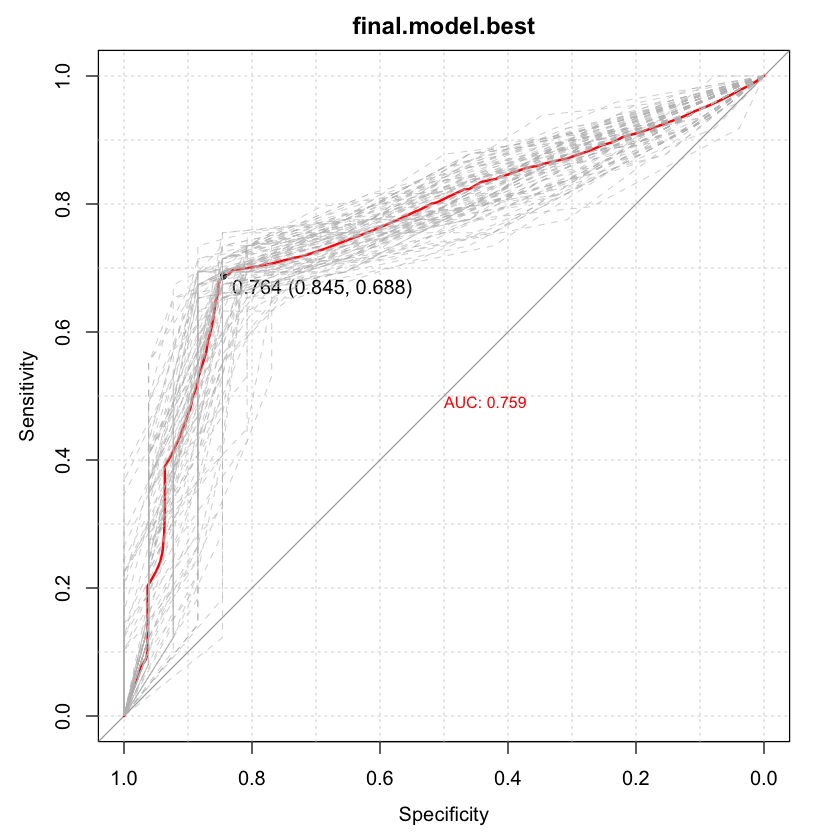

In [215]:
# CV ROC performance

# scoring patients with the final model coefs (see selectionFunction options)
model.fit$finalModel
head(model.fit$pred)

# print final CV ROC curve
pROC_obj = roc(model.fit$pred[,"obs"], model.fit$pred[,"Recurring"], direction = "<", method = "best")
plot.roc(pROC_obj, auc.polygon=FALSE, max.auc.polygon=FALSE, grid=TRUE, col = "red",
             #ci = TRUE, ci.type = "bars", #ci.type=c("bars", "shape", "no")
             print.auc=TRUE, print.thres="best", main="final.model.best", asp = NA, print.auc.cex=0.8)
# CV model best sens and spec via Youden's J method == "best"
print(coords(pROC_obj, x="best")) # threshold tested here is for the model score (= prob. of being Recur)

# ROCs across iter
if (n.iter > 1){

for (i in 1:n.iter){
        i = str_sub(paste0("00",i),start = -3)
        res.i = data.frame(model.fit$pred) %>% filter(grepl(glue("Rep{i}"), Resample))
        roc.plot <- suppressMessages(plot(roc(res.i$obs, res.i$Recurring, direction = "<"), print.auc = FALSE, 
                 col = "grey", lty="dashed", alpha=0.5, lwd=0.5, add=TRUE))
    }
}

### label cohort patients with CV model predictions and calculate overfitted Sens and Spec
cv.calls = predict(model.fit, newdata = df.mrd.preur)

df.mrd.preur = df.mrd.preur %>% mutate(CV.Model.Call = cv.calls)

table(df.mrd.preur$disease.positive, df.mrd.preur$CV.Model.Call)

pos = df.mrd.preur %>% filter(df.mrd.preur$disease.positive=="Recurring")
TP = sum(pos$disease.positive==pos$CV.Model.Call)
FN = sum(pos$pos$disease.positive!=pos$CV.Model.Call)

neg = df.mrd.preur %>% filter(df.mrd.preur$disease.positive=="Non.Recur")
TN = sum(neg$disease.positive==neg$CV.Model.Call)
FP = sum(neg$disease.positive!=neg$CV.Model.Call)

sens = TP/(TP+FN)
spec = TN/(TN+FP)
glue("CV Model Sensitivity: {sens}")
glue("CV Model Specificity: {spec}")

# averaging across all reps (500 values per patient) - AUC = 0.741, not better
# final.preds = res %>% group_by(rowIndex, obs) %>% summarize(avg.score=median(Recurring),
#                                                            final.pred=floor(median(pred)))
# roc.plot <- plot(roc(final.preds$obs, final.preds$final.score, direction = "<"), print.auc = TRUE, 
#                  col = "red", lwd=2, main="fold.score.averaging")

# across folds+iterations
# for (f in 1:n.folds){
#     for (i in 1:n.iter){
#         i = str_sub(paste0("00",i),start = -3)
#         res.i = res %>% filter(Resample == glue("Fold{f}.Rep{i}"))
#         roc.plot <- suppressMessages(plot(roc(res.i$obs, res.i$Recurring, direction = "<"), print.auc = FALSE, 
#                  col = "grey", lty="dashed", alpha=0.8, add=TRUE))
#     }
# }
# across folds only
# for (f in 1:n.folds){
#         res.i = res %>% filter(grepl(glue("Fold{f}"), Resample))
#         roc.plot <- plot(roc(res.i$obs, res.i$Recurring, direction = "<"), print.auc = FALSE, 
#                  col = "grey", lty="dashed", alpha=0.8, add=TRUE)
#     }


In [99]:
names(model.fit)

# model.fit$finalModel

# plot(model.fit$finalModel, uniform=TRUE,
#      main="Classification Tree")

# text(model.fit$finalModel, use.n.=TRUE, all=TRUE, cex=.8)

# fancyRpartPlot(model.fit$finalModel)

res = model.fit$results

model.fit$pred


## prediction
# iris.pred = predict(iris.tree, newdata = test.set)
# table(iris.pred, test.set$species)

# error.rate = round(mean(iris.pred != test.set$species),2)
# error.rate

[1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
[16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
[21] "levels"       "terms"        "coefnames"    "xlevels"

,maxdepth,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.7673481,0.8245333,0.6977333,0.09437244,0.1827641,0.146678


pred,obs,Non.Recur,Recurring,rowIndex,maxdepth,Resample
<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Recurring,Recurring,0.11764706,0.8823529,6,2,Fold1.Rep001
Recurring,Recurring,0.11764706,0.8823529,10,2,Fold1.Rep001
Non.Recur,Recurring,0.79545455,0.2045455,11,2,Fold1.Rep001
Recurring,Recurring,0.11764706,0.8823529,16,2,Fold1.Rep001
Non.Recur,Non.Recur,0.79545455,0.2045455,18,2,Fold1.Rep001
Recurring,Recurring,0.11764706,0.8823529,19,2,Fold1.Rep001
Non.Recur,Non.Recur,0.79545455,0.2045455,25,2,Fold1.Rep001
Recurring,Recurring,0.11764706,0.8823529,28,2,Fold1.Rep001
Recurring,Recurring,0.11764706,0.8823529,31,2,Fold1.Rep001


# Methylation for preRepeat MRD 

In [128]:
pdf(glue("./Manuscript/plots/NMIBC_PreRepeatUrine_LPvsPanel_scatter_{Sys.Date()}.pdf"), 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
# ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.PBMC)) + 
#     #geom_point(size=4) + 
#     scale_y_continuous(trans='log2', labels=scaleFUN) +
#     scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
#     #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
#     theme(text=element_text(size=16)) +
#     ylab("Panel tumorFraction")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, 
                               label=SampleID #PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

dev.off()

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

In [128]:
pdf(glue("./Manuscript/plots/NMIBC_PreRepeatUrine_LPvsPanel_scatter_{Sys.Date()}.pdf"), 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
# ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.PBMC)) + 
#     #geom_point(size=4) + 
#     scale_y_continuous(trans='log2', labels=scaleFUN) +
#     scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
#     #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
#     theme(text=element_text(size=16)) +
#     ylab("Panel tumorFraction")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, 
                               label=SampleID #PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

dev.off()

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

In [170]:
pdf(glue("./Manuscript/plots/NMIBC_PreRepeatUrine_LPvsPanel_scatter_{Sys.Date()}.pdf"), 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
# ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.PBMC)) + 
#     #geom_point(size=4) + 
#     scale_y_continuous(trans='log2', labels=scaleFUN) +
#     scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
#     #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
#     theme(text=element_text(size=16)) +
#     ylab("Panel tumorFraction")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive#, 
                               #label=SampleID #PatientID
                              )) + 
    geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

dev.off()

ERROR while rich displaying an object: Error in `geom_text()`:
! Problem while setting up geom.
ℹ Error occurred in the 2nd layer.
Caused by error in `compute_geom_1()`:
! `geom_text()` requires the following missing aesthetics: label.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare

pdf 
  2

In [128]:
pdf(glue("./Manuscript/plots/NMIBC_PreRepeatUrine_LPvsPanel_scatter_{Sys.Date()}.pdf"), 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
# ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.PBMC)) + 
#     #geom_point(size=4) + 
#     scale_y_continuous(trans='log2', labels=scaleFUN) +
#     scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
#     #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
#     theme(text=element_text(size=16)) +
#     ylab("Panel tumorFraction")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, 
                               label=SampleID #PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

dev.off()

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

In [128]:
pdf(glue("./Manuscript/plots/NMIBC_PreRepeatUrine_LPvsPanel_scatter_{Sys.Date()}.pdf"), 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
# ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, shape=has.PBMC)) + 
#     #geom_point(size=4) + 
#     scale_y_continuous(trans='log2', labels=scaleFUN) +
#     scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
#     #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
#     theme(text=element_text(size=16)) +
#     ylab("Panel tumorFraction")

ggplot(df.mrd.ind.pre.plt, aes(x=cnbScore, y=tumorFraction.final.PERCENT, color=disease.positive, 
                               label=SampleID #PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

dev.off()

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


pdf 
  2

In [244]:
# df_ngsqc.preur = read.csv("./tissue_probe_mrd/tmp_mrd_data_set.csv")
# head(df_ngsqc.preur)

# df_lpwgs_all = read.csv("./tissue_probe_mrd/LPWGS_data_all_11062023.csv")
# head(df_lpwgs_all)

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,has.PBMC,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,wgsTumorfrac_EM
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<lgl>,<int>,<chr>,<int>,<int>,<lgl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.0005111168,0.000000e+00,0.000000e+00,0.04111842,0.27262814,6.7612,0.28133,0.28133,0.000000e+00,0.001874776,0.000000e+00,0.000000e+00,0.0000e+00,0.000000e+00,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362,TRUE,0.0259,60.137,1843520,5.298889,0.0000000
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.0225491599,1.627251e-02,1.338526e-02,10.80395545,0.09633794,51.9150,0.68347,0.68347,1.689107e-01,0.234063133,1.389407e-01,9.496180e-02,1.9501e-01,1.950103e-01,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983,TRUE,0.0000,55.043,2358302,5.685603,0.0000000
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.0032525463,1.770314e-03,1.336200e-03,0.89898273,0.07938568,23.4690,0.26590,0.26590,2.230017e-02,0.040971448,1.683176e-02,4.475564e-03,1.7819e-02,1.781946e-02,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558,TRUE,0.0000,23.266,1936359,3.564916,0.0000000
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.0027979252,2.641349e-03,1.420949e-03,0.54013783,0.20652446,59.8930,0.66059,0.66059,1.278952e-02,0.013547670,6.880296e-03,4.545054e-03,1.0745e-02,1.074472e-02,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334,TRUE,0.0000,22.463,2382513,3.521956,0.0000000
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.0002495944,7.060887e-06,7.060887e-06,0.04056795,0.13272485,19.9300,0.34690,0.34690,5.319944e-05,0.001880540,5.319944e-05,1.845488e-05,1.8455e-05,1.845488e-05,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530,TRUE,0.0000,16.653,2134340,3.318286,0.0000000
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.0017553191,1.625665e-03,1.625665e-03,0.45012604,0.26793088,17.6140,0.67709,0.29952,6.067479e-03,0.006551388,6.067479e-03,1.817331e-03,8.9622e-03,8.962180e-03,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851,TRUE,0.1427,812.660,2015010,9.686186,0.4306547


,SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Fragment_Size_Mode,Softclip.ratio,ProjectDir,coveredGenomicPect,coverage,qcLabel,gender,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,classificationLabel,binNum,cnvbinNum,cnabinNum,cnlbinNum,cnvbinRatio,neutbinNum,neutbinRatio,wgsTumorfrac_EM,externalSampleID,SampleID.short,SampleType,StudyVisit,PatientID,disease.positive
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>
1,P220068_WGS,1190,1180,99.5,647,45.2,157,0.985,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.1,26.84,Pass,female,0.1273,992.271,26924036,10.046665,highRisk,2442,1321,838,483,0.541,412,0.169,0.3592600,06S22068061,P220068,Tissue,IndexTURBT,172229,TRUE
2,P220069_WGS,1210,1200,99.7,623,48.2,147,0.530,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,24.92,Pass,male,0.3867,1884.494,26393139,11.002190,highRisk,2441,1330,430,900,0.545,1078,0.442,0.4733614,06S22035975,P220069,Tissue,IndexTURBT,172586,TRUE
3,P220070_WGS,1200,1190,99.7,650,45.5,180,0.366,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,31.19,Pass,male,0.2390,1258.305,31753729,10.415608,highRisk,2442,1321,599,722,0.541,1062,0.435,0.2534166,06S22052895,P220070,Tissue,RepeatTURBT,172586,TRUE
4,P220073_WGS,973,970,99.6,538,44.5,179,0.429,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,26.80,Pass,male,0.0242,163.316,27302368,7.340233,highRisk,2442,242,92,150,0.099,318,0.130,0.1063838,06S22052894,P220073,Tissue,IndexTURBT,169558,FALSE
5,P220074_WGS,1260,1260,99.7,662,47.4,179,0.408,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,32.62,Pass,male,0.1193,983.514,33927666,9.880656,highRisk,2442,1405,783,622,0.575,488,0.200,0.2080755,06S22036104,P220074,Tissue,IndexTURBT,172851,TRUE
6,P220075_WGS,1140,1130,99.7,630,44.3,183,0.633,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,30.20,Pass,male,0.1407,1200.872,30989435,10.299508,highRisk,2442,1675,814,861,0.686,568,0.233,0.2215777,06S22052897,P220075,Tissue,RepeatTURBT,172851,TRUE


In [332]:
## methyl data

# old methyl data for pre- and post- op urine samples from batch 1+2
# methyl.data1n2 = standardize_names(read_excel("./Methylation_data/batch1n2/region_summary_info_batch1n2.xlsx", sheet="in") %>%
#                                                 mutate(SampleID = Sample.Name)  %>% slice_head(n=44),
#                                    sid.format = "remove.suffix", input.type="samples") %>%
#                 select(-SampleType) %>%
#                 left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
# #warn_na(methyl.data1n2$SampleType)
#table(methyl.data1n2$SampleType, methyl.data1n2$StudyVisit)
methyl.data = read.csv("./Methylation_data/Nov_6_2023/PRDC-MOFFITT-NMIBC-22001_165_samples_Methylation_summary_info_11082023.csv") # missing batch 3 and 4 urine samples
methyl.data = standardize_names(methyl.data %>% mutate(SampleID=Sample.Name) %>% slice_head(n=165),
                                sid.format = "remove.suffix", input.type="samples") %>%
                select(-SampleType) %>%
                mutate(PatientID=fix_PIDs(SubjectID)) %>%
                left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
names(methyl.data)
#write.csv(methyl.data, "./Methylation_data/Nov_6_2023/region_summary_for_client_formatted.csv", row.names=F)
#stop()

#warn_na(methyl.data3n4$SampleType)
#table(methyl.data3n4$SampleType, methyl.data1n2$StudyVisit)
# methyl.data = rbind.common(methyl.data1n2, methyl.data3n4) %>%
#                     mutate(PatientID = fix_PIDs(SubjectID))

methyl.data = methyl.data %>% left_join(df_clin %>% select(PatientID, disease.positive), by="PatientID") %>%
                    mutate(SampleType=ifelse(is.na(SampleType), "Tissue", SampleType), # missing sampletype for benign urotheils
                           disease.positive = factor(disease.positive, levels=c("FALSE","TRUE")))

table(methyl.data$StudyVisit, methyl.data$SampleType)
#head(methyl.data)
#write.csv(methyl.data, "./Methylation_data/all_methyl_data_NMIBC_11062023.csv", row.names=F)

methyl.data.preur = methyl.data %>% filter(StudyVisit=="Pre-Repeat TURBT", 
                                           SampleType == "Urine",
                                           #PatientID %in% pre.urine.mrd.patients # add batch 4 patients
                                          )
table(methyl.data.preur$PatientID)

for (stat in c("filtered_total_abnormal_regions_per_sample",
               "filtered_total_abnormal_frags_per_sample")){
    
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(methyl.data.preur, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(methyl.data.preur, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
    }
    
###
# df_ngsqc.preur = df_ngsqc.preur %>% left_join(methyl.data %>% select(-StudyVisit,-SubjectID,-ExternalID),
#                                                        by="SampleID.short")

## does methyl in preUR predict disease

SampleID.short format: remove.suffix


Standardize.names WARN:Fill all with NA for SampleType



 [1] "116381" "152237" "161922" "165028" "167162" "169558" "171374" "171769"
 [9] "171821" "172153" "172229" "172530" "172586" "172602" "172749" "172851"
[17] "173281" "173334" "173350" "173362" "173509" "173912" "173975" "173983"
[25] "174083" "174091" "174872" "174947" "175325" "175387" "175425" "175492"
[33] "175526" "175610" "175648" "175672" "175725" "175733" "175854" "175980"
[41] "176349" "176388" "176828" "176992" "177967" "178886" "180264" "182022"
[49] "173359"


[1] "SubjectID"                                 
 [2] "StudyVisit"                                
 [3] "ExternalID"                                
 [4] "Sample.Name"                               
 [5] "total_abnormal_regions_per_sample"         
 [6] "total_abnormal_frags_per_sample"           
 [7] "filtered_total_abnormal_regions_per_sample"
 [8] "filtered_total_abnormal_frags_per_sample"  
 [9] "SampleID"                                  
[10] "SampleID.short"                            
[11] "PatientID"                                 
[12] "SampleType"

ERROR: Error in eval(expr, envir, enclos): 


[1] 49

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34



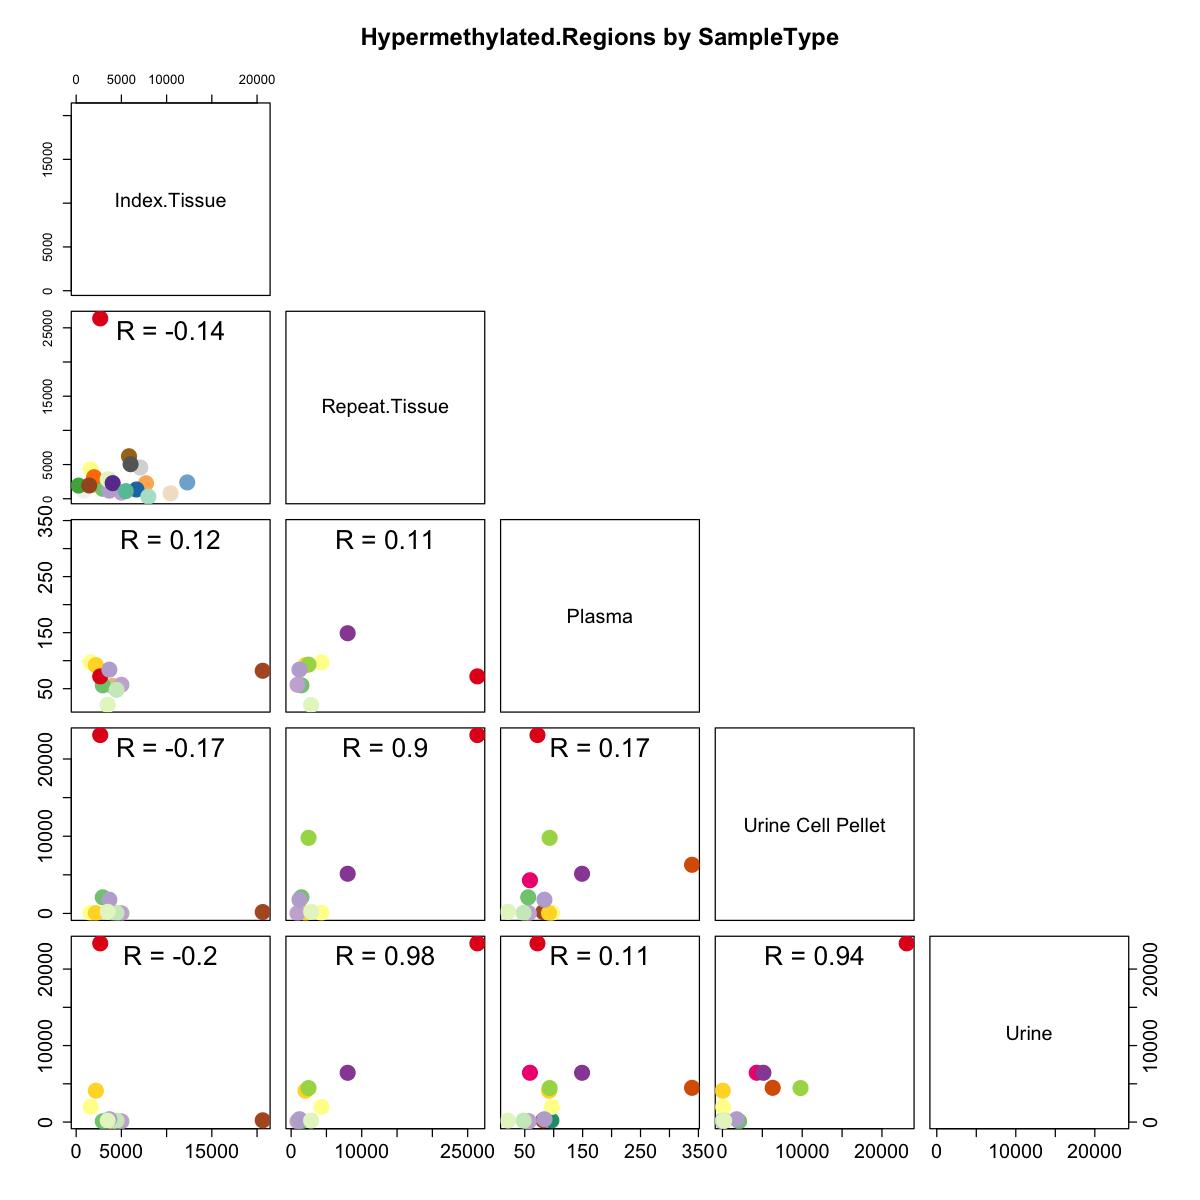


 Index.Tissue        Plasma Repeat.Tissue         Urine          <NA> 
           41            15            28            15             0 

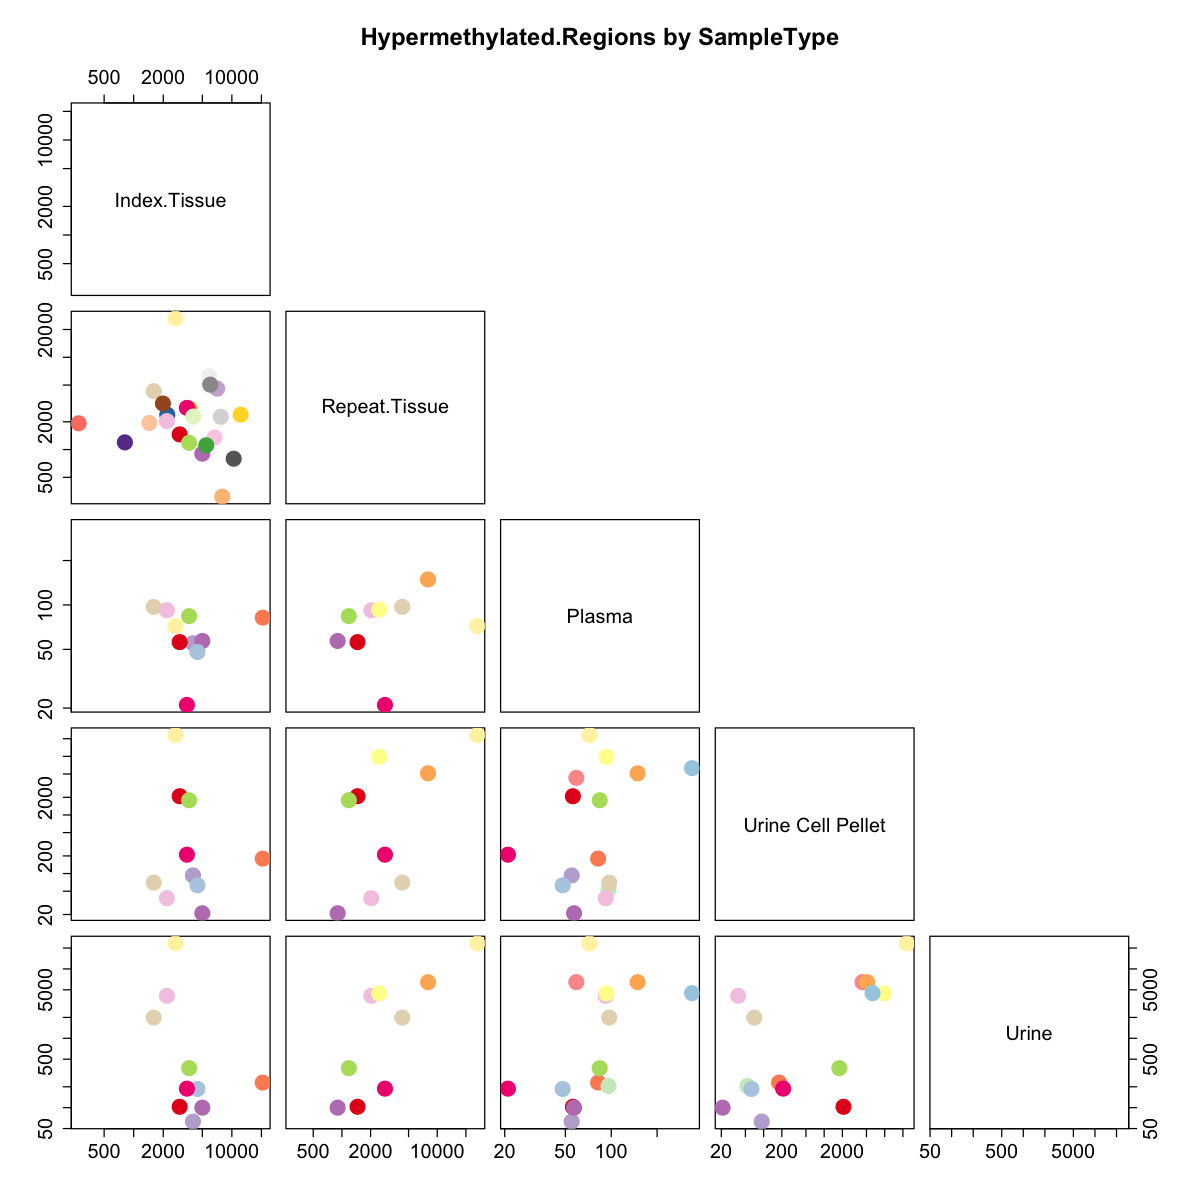

In [330]:
source("~/Desktop/puffin/R/plotFunctions.R")
# pairs plots
# is methyl in index or repeat correlated with preUR
# how does PBMC data help us?
# corr urine vs plasma vs. ucp vs. tissue
# benign vs cancer patterns?
# methyl vs lpwgs?
df_plot = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma", "Urine Cell Pellet")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType) %>%
            pivot_wider(id_cols = "PatientID", names_from = "SampleType", names_sep = ".",values_from = "Hypermethylated.Regions")
nrow(df_plot) #49 patients
warn_na(df_plot)
options(repr.plot.width=10, repr.plot.height=10)
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=FALSE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=TRUE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")

df_count = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType)
     
table(df_count$SampleType)

,subject_id,study_visit,external_ID,requisition_ID,chr,start,end,width,mean_fragment_beta,abnormal_fragments,log10_p.value,gene_symbol,annotation_type,CGI_overlap,CpG_num,TSS_dist,nearest_transcript,transcript_overlap
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<lgl>,<int>,<int>,<chr>,<lgl>
1,116381,IndexTURBT,06S23005718,P228837_M,chr1,975335,975586,251,0.74,6,18,AGRN,hg19_genes_introns,TRUE,15,19833,uc001ack.2,TRUE
2,116381,IndexTURBT,06S23005718,P228837_M,chr1,975586,975837,251,0.88,5,15,AGRN,hg19_genes_introns,TRUE,19,20084,uc001ack.2,TRUE
3,116381,IndexTURBT,06S23005718,P228837_M,chr1,1474938,1475189,251,0.72,3,9,TMEM240,hg19_genes_exons,TRUE,27,551,uc009vkf.3,TRUE
4,116381,IndexTURBT,06S23005718,P228837_M,chr1,6268983,6269234,251,0.72,4,12,RNF207,hg19_genes_5UTRs,TRUE,31,2795,uc001amg.3,TRUE
5,116381,IndexTURBT,06S23005718,P228837_M,chr1,9065203,9065454,251,0.70,4,12,SLC2A7,hg19_genes_introns,FALSE,9,20950,uc009vmo.1,TRUE
6,116381,IndexTURBT,06S23005718,P228837_M,chr1,18956101,18956352,251,0.77,4,12,PAX7,hg19_genes_1to5kb,FALSE,13,1148,uc001bay.3,FALSE



              hg19_genes_1to5kb                hg19_genes_5UTRs 
                          80882                           22428 
               hg19_genes_exons           hg19_genes_intergenic 
                          63396                          100334 
hg19_genes_intronexonboundaries              hg19_genes_introns 
                            189                           97772 
           hg19_genes_promoters                            <NA> 
                         104339                               0 

SampleID.short format: remove.suffix


[1] 4

[1] "Index.Tissue"  "Repeat.Tissue" "Urine"         "Plasma"

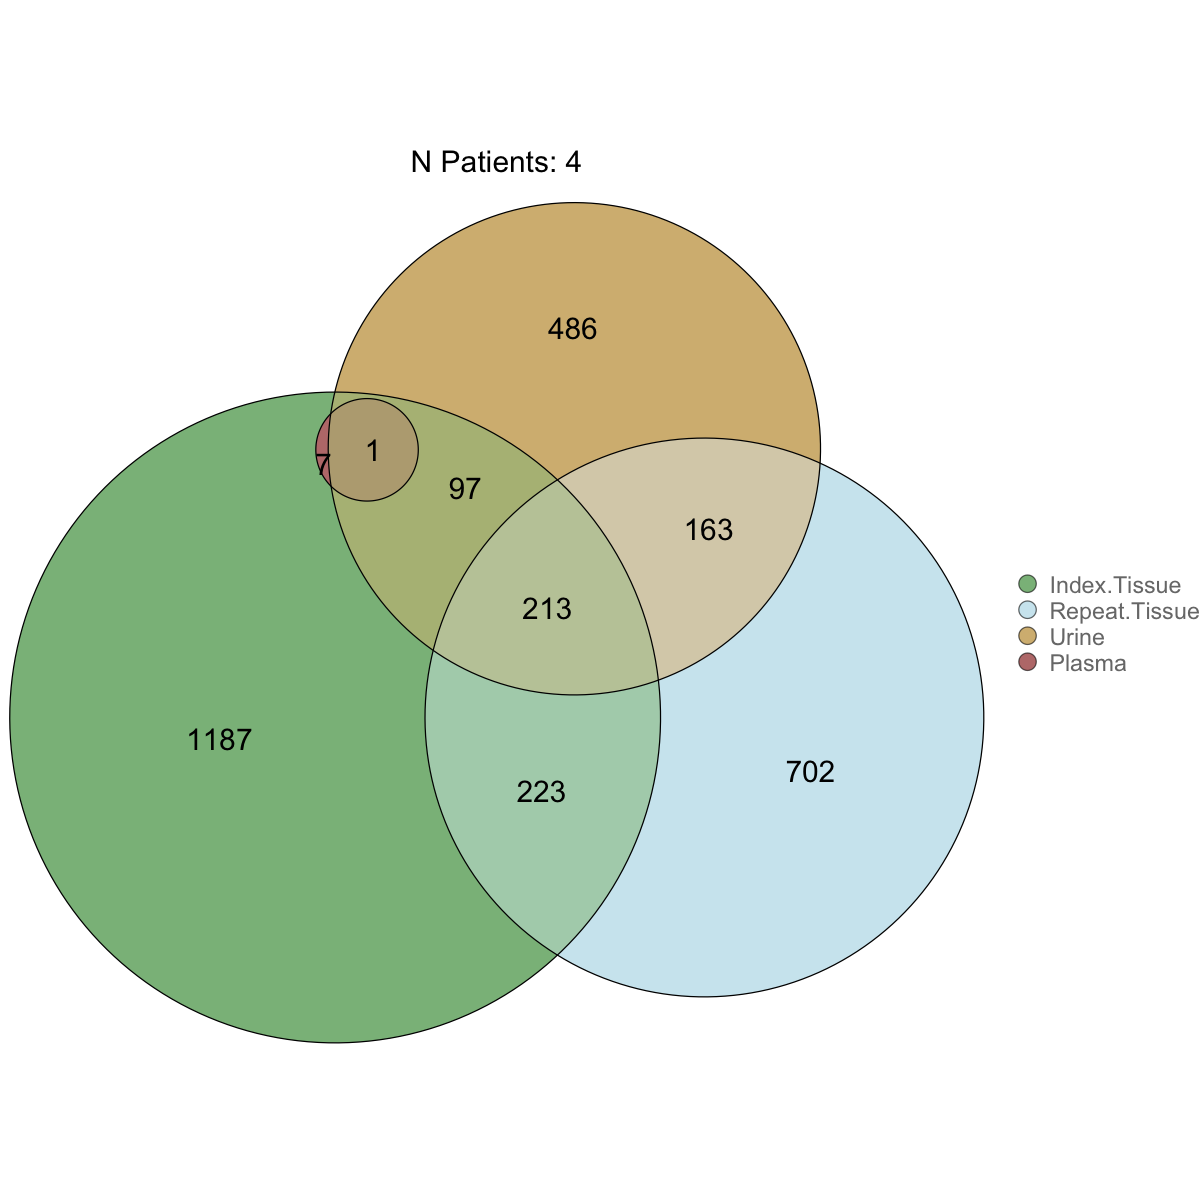

In [297]:
source("~/Desktop/puffin/R/get_concordance_stats.R")

methyl.regions = read.csv("./Methylation_data/Nov_6_2023/test_sample_abnormal_regions_11062023.csv")
head(methyl.regions)
table(methyl.regions$annotation_type)


methyl.promoters = methyl.regions %>% filter(requisition_ID %in% methyl.data$SampleID,
                                             annotation_type == "hg19_genes_promoters",
                                            !is.na(gene_symbol)) %>%
                        mutate(label=paste(subject_id, gene_symbol, sep=":"),
                               SampleID.short = make_SIDshort(requisition_ID, "remove.suffix")) %>% 
                        left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short") %>%
                        filter(study_visit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                              SampleType %!in% c(#"Plasma", 
                                                  "Buffycoat", "Urine Cell Pellet"
                                                )) %>%
                        mutate(SampleType=ifelse(study_visit=="IndexTURBT", "Index.Tissue",
                                        ifelse(study_visit=="RepeatTURBT", "Repeat.Tissue", SampleType)))
samples = methyl.promoters %>% group_by(subject_id) %>% mutate(n_samples=length(unique(SampleType))) %>%
            filter(n_samples >= 4)
methyl.promoters = methyl.promoters %>% filter(subject_id %in% samples$subject_id)

warn_na(methyl.promoters$SampleType)
warn_na(methyl.promoters$study_visit)
n.patients = length(unique(samples$subject_id))
n.patients

plot_list = list()
for (st in unique(methyl.promoters$SampleType)){
    plot_list[[st]] = unique(methyl.promoters %>% filter(SampleType==st) %>% pull(label))
}
names(plot_list)
v <- euler(plot_list) # function converts list to alphabetical order by label
  eulerr_options(padding = unit(5, "mm"))
  plot(v, quantities = list(type = "counts", cex=1.5),
          fills = list(fill = c("forestgreen","lightblue","darkgoldenrod","darkred"), alpha=0.6),
          legend = list(plot=TRUE, fontsize = 14),
          main=glue("N Patients: {n.patients}"))

In [321]:
genes = plot_list[["Urine"]][plot_list[["Urine"]] %in% plot_list[["Repeat.Tissue"]][plot_list[["Repeat.Tissue"]] %in% plot_list[["Index.Tissue"]]]]
length(genes)
#sort(genes)
table(methyl.promoters$subject_id)

genes = unlist(lapply(genes, function(x) str_split(x,":")))
genes = sort(genes[genes %!in% unique(methyl.promoters$subject_id)])
matrix(c(unique(genes), rep("",6)), ncol=10)
                      
table(methyl.)

[1] 215


171769 172229 173334 173509   <NA> 
  1662   1732   1190    971      0 

AARD,BCL2L11,CRISPLD1,GOLPH3L,IFT80,MEGF11,OTX1,PROCA1,SMTN,VOPP1
ACAT2,BCL6,CRYBG1,GPR78,IQUB,MERTK,OXCT2,PROSER3,SNX32,WDR87BP
ACIN1,BDNF,DBNDD2,GPX3,KAT7,MGA,PABPC1L,PUM2,SOX2,WNT3
ACTRT3,BOLL,DGKI,GSK3A,KCNIP2,MIR196A2,PAX6,RAB12,SP9,ZNF135
ADAMTSL1,C17orf107,DLX6-AS1,H2BC9,KLF11,MKNK2,PCDHGB5,RAB31,SPACA6,ZNF154
ADGRD2,CA3,DMRTA2,H3C12,KLF4,MLH1,PCDHGB6,RASSF1,SPAG6,ZNF418
ADHFE1,CALB1,DYNLT2B,H4C6,KLHDC9,MLX,PCDHGC4,RBP1,SPATA20,ZNF667-AS1
AFAP1L2,CCDC106,EHBP1-AS1,HLF,LAMB1,MSC,PENK,REC8,TBX15,ZNF701
AKR1E2,CCDC13,EPHB4,HOXA11,LBX2,MSC-AS1,PER1,RGS22,TBX4,ZNF709
ALX1,CD93,EPHX3,HOXB-AS1,LEPR,MT1A,PFKFB4,RHBDL1,TCF7,ZNF813
AMIGO3,CDKN2A-DT,EPS8L1,HOXB5,LINC00526,MTMR7,PHF11,RSPH6A,TJP2,ZNF814


In [6]:
## sumarize urine beacon # rerun
## number of baseline probes, # number of probes conf. detected 
    # mrd score # number new mutations detected #urine tumorFraction without new muts ## tumroFrac with new muts.
#select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction_0")
mrd.table = df_mrd_pre %>% rename("N.baseline.muts.detected.mrdInfo"=mutationCount,
                                  "N.personal.probes.detected.mrdInfo"=mutationCount.mrd,
                                  "N.probes.detected.dynamic.mrdInfo"=mutationCount.mrd.f,
                                  "MRD.score"=mrd.score,
                                  "MRD.call"=mrd.status,
                                  "TF.all.muts.mrdInfo"=tumorfraction.baseline,
                                  "TF.dynamic.muts.mrdInfo"=tumorfraction.baseline.adj,
                                  "TF.dynamic.highqual.muts.mrdInfo"=tumorFraction) %>% 
               select(SampleID.short, PatientID, SampleType, StudyVisit, 
                      #"N.baseline.muts", #extract this one
                      N.baseline.muts.detected.mrdInfo, 
                      #"N.personal.probes", #extract this one
                      N.personal.probes.detected.mrdInfo, 
                      MRD.score, MRD.call,
                      TF.dynamic.muts.mrdInfo, 
                      TF.dynamic.highqual.muts.mrdInfo)
mrd.table

SampleID.short,PatientID,SampleType,StudyVisit,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,MRD.call,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
P219768,173362,Urine,Pre-Repeat TURBT,2,2,1.00,FALSE,0.281,0.0000000000
P219770,172229,Urine,Pre-Repeat TURBT,72,64,8.75,TRUE,0.643,0.6641799480
P219771,173334,Urine,Pre-Repeat TURBT,72,70,68.50,TRUE,0.676,0.0039131614
P219774,171769,Urine,Pre-Repeat TURBT,42,35,2.50,TRUE,0.685,0.2373843811
P217590,172851,Urine,Pre-Repeat TURBT,39,36,9.25,TRUE,0.677,0.1625357483
P217591,172586,Urine,Pre-Repeat TURBT,27,29,2.50,TRUE,0.705,0.3306003890
P217592,173983,Urine,Pre-Repeat TURBT,40,36,36.00,TRUE,0.683,0.0579642593
P217594,169558,Urine,Pre-Repeat TURBT,33,30,31.50,TRUE,0.380,0.0072417228
P217595,161922,Urine,Pre-Repeat TURBT,38,36,29.00,TRUE,0.702,0.0005027954


# Post-surgery MRD analysis

In [ ]:
## NOTES ###

## post-repeat data here: 
#Index of /lbwfresult/OutputByRunB21/20230908_LH00191_0032_A2272KNLT3_runtask_230910131244_beff989e/dsrun1.7.1/lbwfresult1.7.1

# in dat folder see also sampleid_MRD.rds file, contains variants used for each baseline test.

# mutationCount.baseline.design - all baseline variants available in input panel
# mutationCount.baseline - all baseline variants that were detected in the sample
# excludeCount - variants that were not detected or excluded based on germline status, low quality, etc.
# mutationCount - all somatic variants detected in the sample
# mutationCount.mrd - somatic T00 personalized variants (?)
# mutationCount.mrd.f - somatic personailzed variants that change significantly in freq (from baseline?) or are white.list
# checkDynamic = true only if min sample white.list VAF (compared with baseline?) is greater than some threshold

In [ ]:
## BEACON DATA

# batch 1,2,3 hybrid baseline mrd
mrd.info2 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/WOP01079_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all (1) (1).csv", as.is=T) %>%
                rename("Baseline.SID"="Baseline") %>% select(-PatientID) 
#mis1 = read.csv("./hybrid_probe_mrd/hybrid_mrd_data/missing_mrd_outputs_batch3/P228747_consensus_mrdInfo.csv")
#mis2 = read.csv("./hybrid_probe_mrd/hybrid_mrd_data/missing_mrd_outputs_batch3/P228782_consensus_mrdInfo.csv")
#mis3 = read.csv("./hybrid_probe_mrd/hybrid_mrd_data/missing_mrd_outputs_batch3/P228813_consensus_mrdInfo.csv")
#mis = rbind(mis1, mis2, mis3)
#mrd.info2 = rbind.common(mrd.info2, mis) 

##batch 1 +2 tissue basline mrd data (not included in AUA2024 abstract) - needs rerun with new target info files and pipeline callmrd for multibaselines
# some samples re-analyzed with batch 3 above with newly-designed hybrid panels that include urine baseline
mrd.info1 = read.csv("tissue_probe_mrd/post_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011_mrdInfo_combined_POST_2023-10-19.csv") %>%
                rename("Baseline.SID"="Baseline") %>% select(-PatientID) %>%
                filter(SampleID %!in% mrd.info2$SampleID)
#head(mrd.info1)
mrd.info = rbind.common(mrd.info1, mrd.info2)
table(mrd.info$SampleID)
#mrd.info %>% filter(SampleID == "P217599") # max 6 mrd outputs per sample

# attach baseline sample type
mrd.info = mrd.info %>% filter(!grepl("specific", Baseline.SID, ignore.case=T)) %>%
                        left_join(df_samples_all %>% select(SampleID, PatientID, SampleType, StudyVisit),
                                 by = c("Baseline.SID"="SampleID")) %>%
                        rename("PatientID.baseline"="PatientID", "SampleType.baseline"="SampleType", "StudyVisit.baseline"="StudyVisit")
mrd.info$SampleType.baseline[mrd.info$Baseline=="Pool"] <- "Pool"
mrd.info$StudyVisit.baseline[mrd.info$Baseline=="Pool"] <- "Pool"

# attach mrd sample info
mrd.info = mrd.info %>%
                left_join(df_samples_all %>% select(SampleID, PatientID, SampleType, StudyVisit),
                                  by="SampleID") %>%
                        rename("SampleType.sample"="SampleType", "StudyVisit.sample"="StudyVisit") %>%
                        mutate(label.sample=paste(PatientID, StudyVisit.sample, SampleID, sep="-")) %>%
                        
                        filter(StudyVisit.sample %!in% c("Pre-Repeat TURBT", "Pre-RepeatTURBT"))

nrow(mrd.info) # 119
stopifnot(all(mrd.info$PatientID==mrd.info$PatientID.baseline, na.rm = T))

table(mrd.info$StudyVisit.sample)

In [ ]:
# data output
mrd.info = mrd.info %>% left_join(df_lpwgs_all %>% select(-PatientID,-StudyVisit,-SampleType), by=c("SampleID"="SampleID.short"))
head(mrd.info)
write.csv(mrd.info, glue("./hybrid_probe_mrd/hybrid_mrd_data/NMIBC_MRD_data_summary_PostUR_{Sys.Date()}.csv"))
write.csv(mrd.info, glue("./data_delivery/BEACON/NMIBC_MRD_data_summary_PostUR_{Sys.Date()}.csv"))

In [ ]:
# load selected variants
# patients for hybrid panel recurrence testing
patients = c(
#"171374", # urine baseline only, probes not ordered
"171769",
"171821",
"172229",
"172586",
"172602",
#"172749", # urine baseline only, probes not ordered
"172851",
"173075",
#"173254", # urine baseline only, probes not ordered
"173281",
#"173350", # needs tissue-based probes designed, preUR fail
#"173359", # urine baseline only, probes not designed
"173362",
"174083",
"174947",
"175425", 
"175725",
#"175733", # needs tissue-based probes designed, preUR fail
"176388",
"176828"
)

patients.tissue.only.baseline = c('172530','161922','169558','173334','171821','172749','175672'#,
                                  #'175672', excluded by JL
                                  )
# patients = c( # used to design hypbrid panes
#   "171769",
#   "171821",
#   "172229",
#   "172586",
#   "172602",
#   "172749",
#   "172851",
#   "173075",
#   "173281",
#   "173362",
#   "174083",
#   "174947",
#   "175425", # no post-op urine sequenced?
#   #"175648", # exclude - JL
#   #"175672", - exclude from recurrence study - JL
#   "175725", 
#   "176388",
#   "176828")

patients = c(patients, patients.tissue.only.baseline)
# missing patients
print("missing")
patients[patients %!in% mrd.info$PatientID]
print("extra")
mrd.info$PatientID[mrd.info$PatientID %!in% patients]

up.cyst.or.recur.patients = c("172602",
                              "174083",
                              "171769",
                              "172229", 
                              "173281",
                              "172586",
                              "172749",
                              "174947",
                              "176388")# first two had reurr then cystectomy 
urine.baseline.only.patients = c("171374","171821","172749","173254","173359")
up.cyst.patients = c("171769","172229","173281")

# from JL on 10/6 - group patients with recur and cystectomy together #15 patients
# patientID	upfrontcx_or_recurrence	recurrence_surveillance	date_clin_recur	repeat_to_recurr_mon	update notes
# 171769	1	0			cystectomy
# 171821	0	0			
# 172229	1	0			cystectomy
# 172586	1	1	7/8/22	4.8	updated/recurred
# 172602	1	1	10/28/22	8	
# 172749	1	1	1/6/23	10.4	
# 172851	0	0			
# 173075	0	0			
# 173281	1	0			cystectomy
# 173362	0	0			
# 174083	1	1	8/26/22	5.2	
# 174947	1	1	10/7/22	4.7	
# 175725	0	0			
# 176388	1	1	12/1/22	3.6	
# 176828	0	0			


In [ ]:
# add patient relapse data to mrd.info
# use above
mrd.info = mrd.info %>% filter(PatientID %in% patients) %>%
                mutate("UFC.or.Recur"=PatientID %in% up.cyst.or.recur.patients)

df_relapse = read_excel("./ASCO_GU/Urine MRD Probe Patients_JL_09132023.xlsx", sheet="JL_POSTOP_URINE_LIST")
#str(df_relapse)
mrd.info = mrd.info %>% left_join(df_relapse %>% 
                                    select(patient_id, date_of_subsequent_turbt,turbt_recurrence_pathology, 
                                           #date_clin_recur, repeat_to_recurr_mon,surv_tot_time_mo, 
                                           any_cytology_atypical_up, 
                                           any_cytology_suspicious_up, total_follow_mo) %>% 
                                    mutate("PatientID" = as.character(patient_id)), 
                                  by="PatientID") %>% 
                        mutate(PatientID=as.character(PatientID)) %>%
                        arrange(PatientID, StudyVisit.baseline) 
warn_na(mrd.info %>% select(StudyVisit.baseline, StudyVisit.sample))

dim(mrd.info) 
names(mrd.info)
#saveRDS(mrd.info, "./hybrid_probe_mrd/hybrid_mrd_data/mrd_info_annot.rds")
#write.csv(mrd.info %>% select(-PatientID.sample), "./hybrid_probe_mrd/hybrid_mrd_data/mrd_info_annot.csv")

In [ ]:
## use only first post-op urine sample for MRD analysis

mrd.info = mrd.info %>% mutate(StudyVisit.sample=factor(StudyVisit.sample, 
                                            levels=c("PostTURBT", "Surveillance1", "FollowUp1", "FollowUp2", "FollowUp3"),
                                            ordered=TRUE),
                                UFC.or.Recur=factor(UFC.or.Recur, levels=c("FALSE","TRUE")))

mrd.info.first = mrd.info %>% filter(StudyVisit.sample %in% c("PostTURBT", "Surveillance1", "FollowUp1"))
mrd.info.first = mrd.info.first %>% group_by(PatientID) %>% filter(SampleID==SampleID[1]) %>% ungroup()
table(mrd.info.first$PatientID, mrd.info.first$StudyVisit.sample)
table(mrd.info.first$StudyVisit.baseline)


## Pool <- study visit NA

In [ ]:
## MRD prediction of relapse Yes/No

# some patients have only repeat and no index - combine baselines?
source("~/Desktop/puffin/R/helper_functions.R")
options(repr.plot.width=10, repr.plot.height=8)

#why is the lowest non-zero TF value in the cohort lower than the LOD==0.0001 ???, skip lod fill for now
mrd.info.lod <- mrd.info.first %>% filter(Baseline.SID != "Pool",
                                          PatientID %!in% up.cyst.patients) ## exclude 3 - not improved
nrow(mrd.info.lod)
table(mrd.info.lod$SampleType.baseline) 

#pdf("./AUA/Relapse_Prediction_Boxplots_11042023.pdf", width=15, height=7, onefile = TRUE)
colors=c("FALSE"="steelblue","TRUE"="darkred")
vars = c("tumorFraction", "tumorFraction.mrd", "tf.m.f")
for (var in vars){
    warn_na(mrd.info.lod[[var]])
    pseudo.LOD = min(mrd.info.lod[[var]][mrd.info[[var]]!=0], na.rm = T)/2
    g <- quick_boxplot(df = mrd.info.lod, x="UFC.or.Recur", y=var, log.axes = TRUE, 
                  log.0.adj = pseudo.LOD,
                  facet="StudyVisit.baseline", print.p = T, colors=c("FALSE"="steelblue","TRUE"="darkred"))
    show(g)
}
vars = c("mrd.score", "mrd.score.noNovel")
for (var in vars){
    warn_na(mrd.info.lod[[var]])
    pseudo.LOD = min(mrd.info.lod[[var]][mrd.info[[var]]!=0], na.rm = T)/2
    g <- quick_boxplot(df = mrd.info.lod, x="UFC.or.Recur", y=var, log.axes = FALSE,
                  facet="StudyVisit.baseline", print.p = T, colors=c("FALSE"="steelblue","TRUE"="darkred"))
    show(g)
}
#dev.off()

## power calculations

In [83]:
# power calc for validation cohort - # rerun
# to detect significant difference in median tumor fraction between disease.positive/disease.negative at reTUR
# power curve: Significance vs. sample size given obsv. effect size
# https://cinnipatel.medium.com/power-curve-in-r-8a1e67fb2600

library(WMWssp)
# how many samples required to have 80% power to detect given effect size with confidence alpha=0.01 (p val, FPR)
plot_MWU <- function(case_vals, control_vals, power, metric=""){
    x = case_vals[!is.na(case_vals)]
    y = control_vals[!is.na(control_vals)]
    #effect_size = round(((mean(x) - mean(y))/mean(y)) * 100, 1)  #pct avg decrease from disease.positive to disease.nge
    effect_size = round((median(x) - median(y)), 3)
    print(effect_size)
    sig.level.list <- seq(.01,0.10,.01)  #Vector of sig..level 
    samp.out <- NULL
    for(a in sig.level.list){
      ssp <- WMWssp(x , 
                  y,
                  alpha = a, 
                  power = power, 
                  t = 7/10, 
                  simulation=T, nsim=100)
      res = summary(ssp)
      n.xxx  <-  res$Results[[9]]
      print(n.xxx)
      n.xxx <- data.frame(sig.level=a, sample.size=n.xxx)
      samp.out <- rbind(samp.out,n.xxx)
    }
    gg <- ggplot(samp.out, aes(sample.size,sig.level))+
      geom_line() + theme(text=element_text(size=15)) +
      #theme_minimal() +
      geom_hline(yintercept = .05,lty=2, color='blue') +
      geom_point() +
      labs(title=sprintf("Wilcoxon test, power=0.80\n%s = %s", metric, effect_size),
           y="Significance Level (p-value)",
           x="Sample size")
    show(gg)
    return(samp.out)
    }

[1] 0.019
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9800000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


[1] 0.162
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9700000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

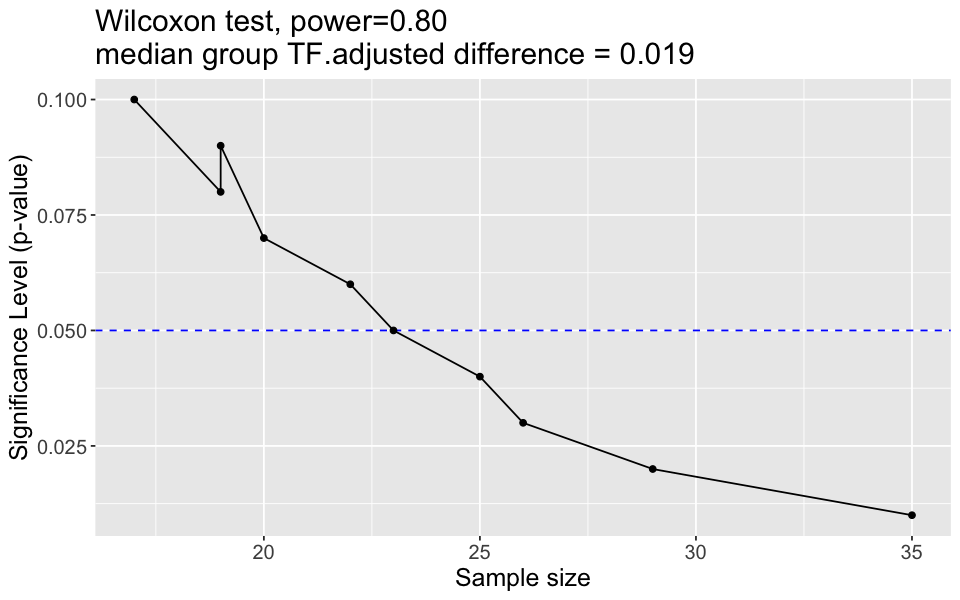

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


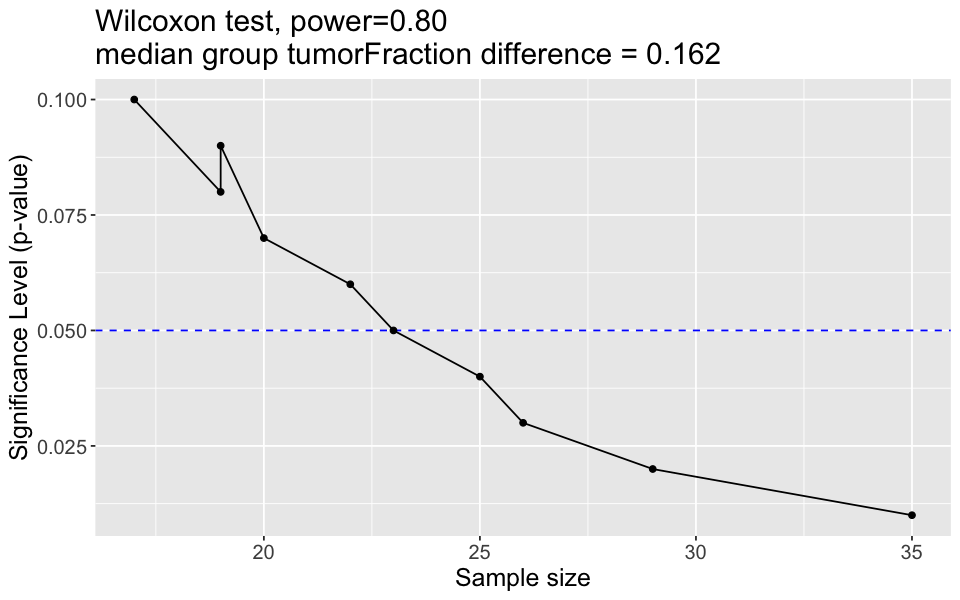

In [88]:
## BEACON tumorFraction measures
plot_MWU(df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group TF.adjusted difference")

plot_MWU(df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group tumorFraction difference")

[1] 0.055
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1428571
N (total sample size needed) 27.1327432
t=n1/N                        0.7000000
n1 in Group 1                18.9929202
n2 in Group 2                 8.1398229
N rounded                    28.0000000
n1 rounded                   19.0000000
n2 rounded                    9.0000000
[1] 28
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9200000
Estimated relative effect p   0.1428571
N (total sample size needed) 22.8659188
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,28
0.02,24
0.03,22
0.04,20
0.05,19
0.06,17
0.07,16
0.08,16
0.09,15


[1] 0.109
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                               Results
alpha (2-sided)               0.010000
Power                         0.800000
Simulated Power               0.970000
Estimated relative effect p   0.177381
N (total sample size needed) 31.113570
t=n1/N                        0.700000
n1 in Group 1                21.779499
n2 in Group 2                 9.334071
N rounded                    32.000000
n1 rounded                   22.000000
n2 rounded                   10.000000
[1] 32
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                               Results
alpha (2-sided)               0.020000
Power                         0.800000
Simulated Power               0.950000
Estimated relative effect p   0.177381
N (total sample size needed) 26.238465
t=n1/N                     

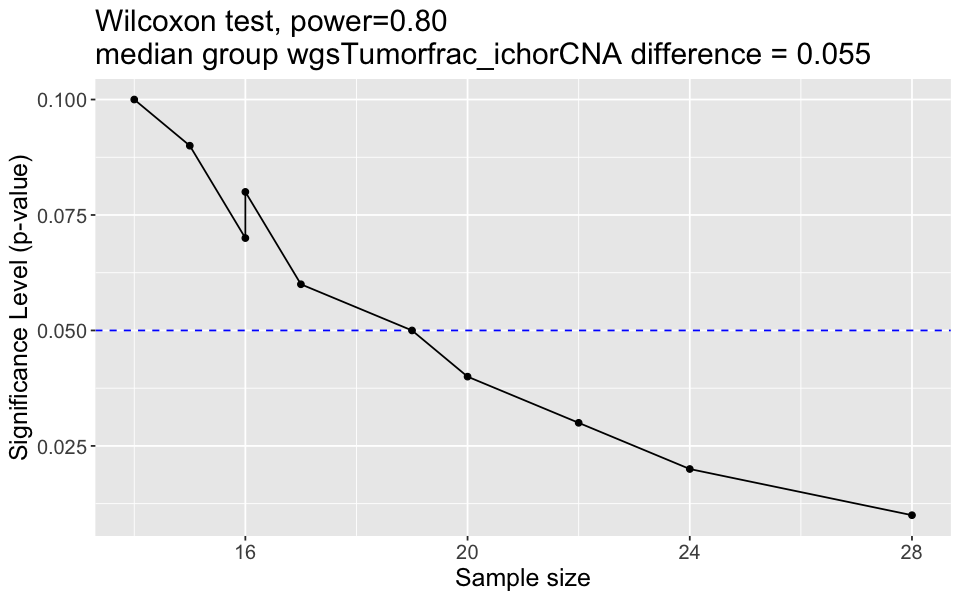

sig.level,sample.size
<dbl>,<dbl>
0.01,32
0.02,27
0.03,25
0.04,22
0.05,20
0.06,19
0.07,19
0.08,17
0.09,17


[1] 4.065
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                              Results
alpha (2-sided)               0.01000
Power                         0.80000
Simulated Power               0.99000
Estimated relative effect p   0.10000
N (total sample size needed) 21.87137
t=n1/N                        0.70000
n1 in Group 1                15.30996
n2 in Group 2                 6.56141
N rounded                    23.00000
n1 rounded                   16.00000
n2 rounded                    7.00000
[1] 23
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                              Results
alpha (2-sided)               0.02000
Power                         0.80000
Simulated Power               0.94000
Estimated relative effect p   0.10000
N (total sample size needed) 18.35170
t=n1/N                        0.70000
n1 in G

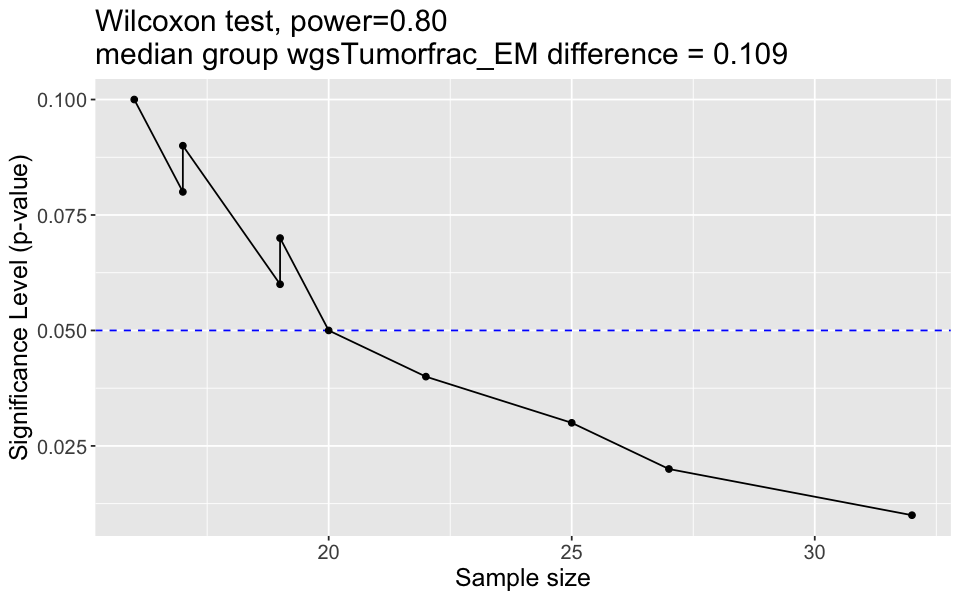

sig.level,sample.size
<dbl>,<dbl>
0.01,23
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


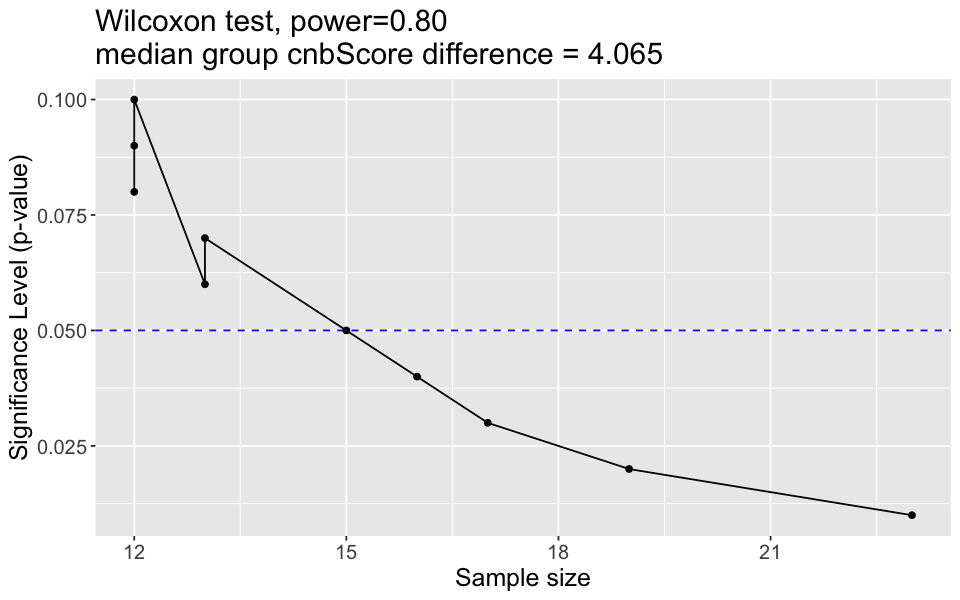

In [89]:
# LPWGS power
plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_ichorCNA difference")

plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_EM difference")

plot_MWU(df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group cnbScore difference")

## LPWGS pre-repeat urine analysis

In [131]:
df_urine_lpwgs_pre = df_lpwgs_all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="Urine") # rerun
nrow(df_urine_lpwgs_pre) # 44
# df = df_urine_pre %>% 
#     select(PatientID, StudyVisit, disease.positive, wgsTumorfrac_ichorCNA) %>% arrange(PatientID)
# write.csv(df, "./pre_repeat_urine_WGS_TF_list.csv", row.names=F)
source("~/Desktop/puffin/R/helper_functions.R")

[1] 44

Complete cases wgsTumorfrac_ichorCNA by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.07135

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 30, p-value = 3.589e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_ichorCNA    label
1            FALSE                0.4651 p=<0.001
2             TRUE                    NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



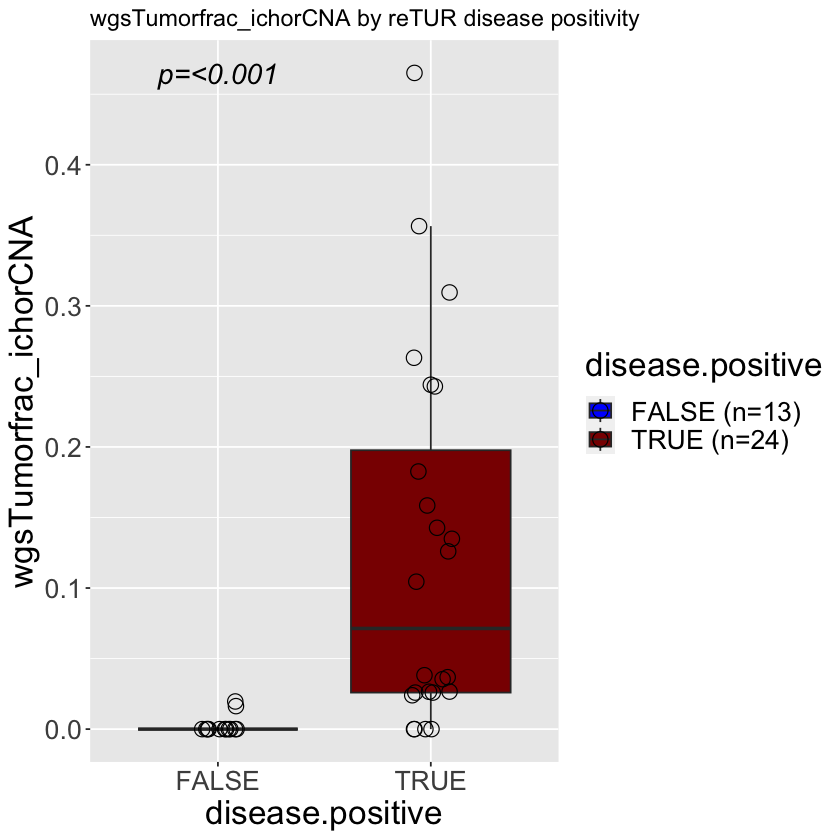

  threshold specificity sensitivity
1    0.0218           1   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.903846153846154"
Complete cases cnbScore by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 3.88570603348226
TRUE median: 8.1595036851768

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 23, p-value = 2.494e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive cnbScore    label
1            FALSE 10.80927 p=<0.001
2             TRUE       NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



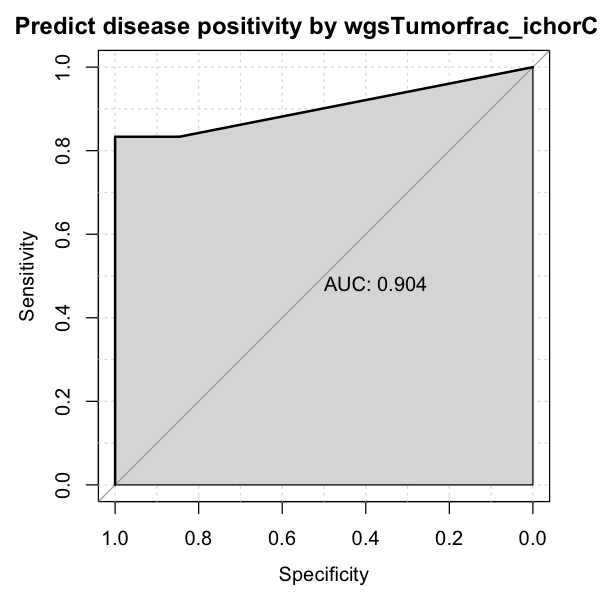

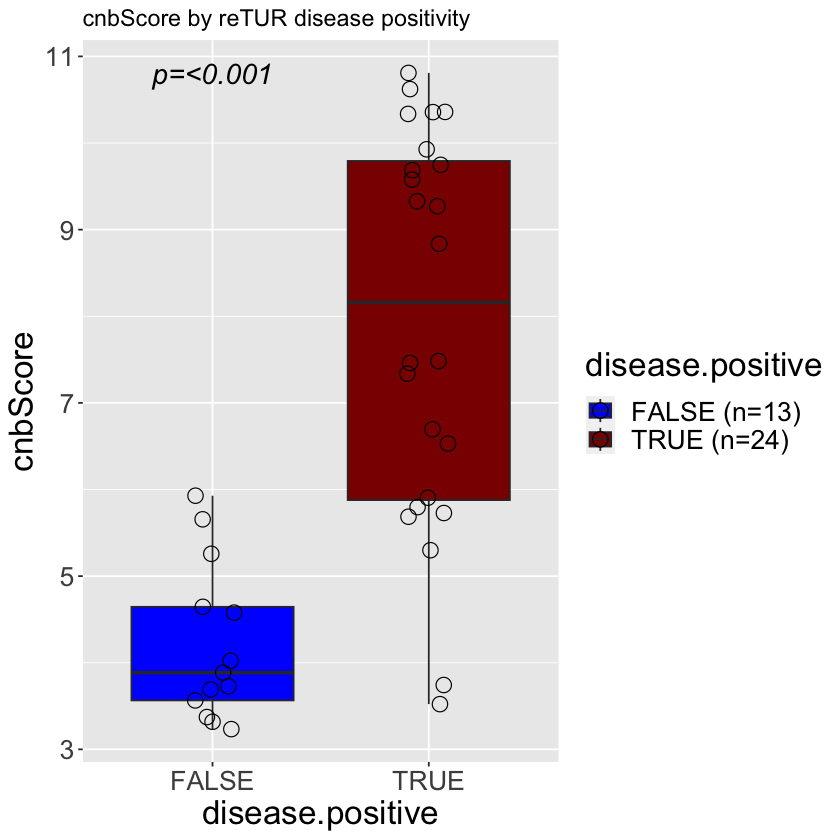

  threshold specificity sensitivity
1  5.670669   0.9230769       0.875
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388   0.2307692           1
[1] "AUC: 0.926282051282051"
Complete cases wgsTumorfrac_EM by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.10874038682539

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 45.5, p-value = 0.0001373
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_EM    label
1            FALSE       0.7317695 p=<0.001
2             TRUE              NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



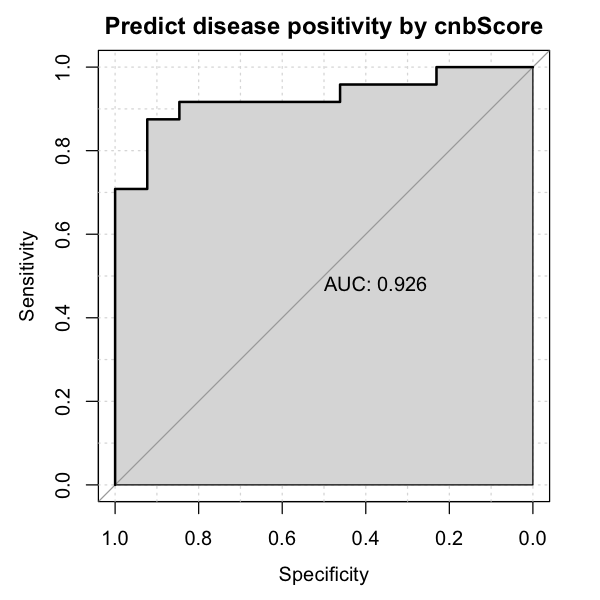

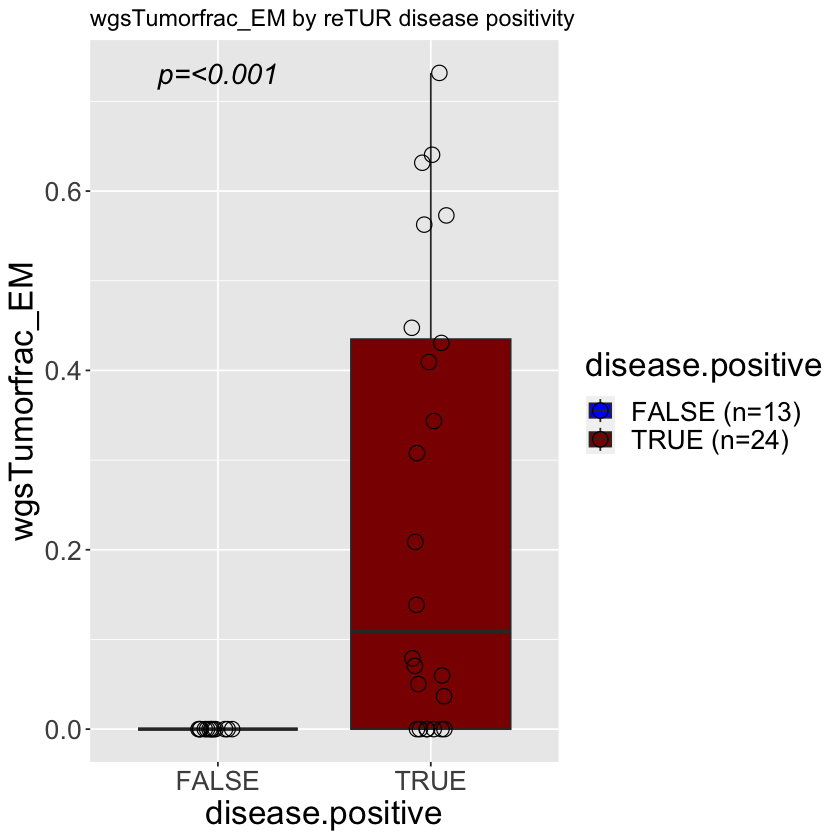

   threshold specificity sensitivity
1 0.01830617           1   0.7083333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.854166666666667"


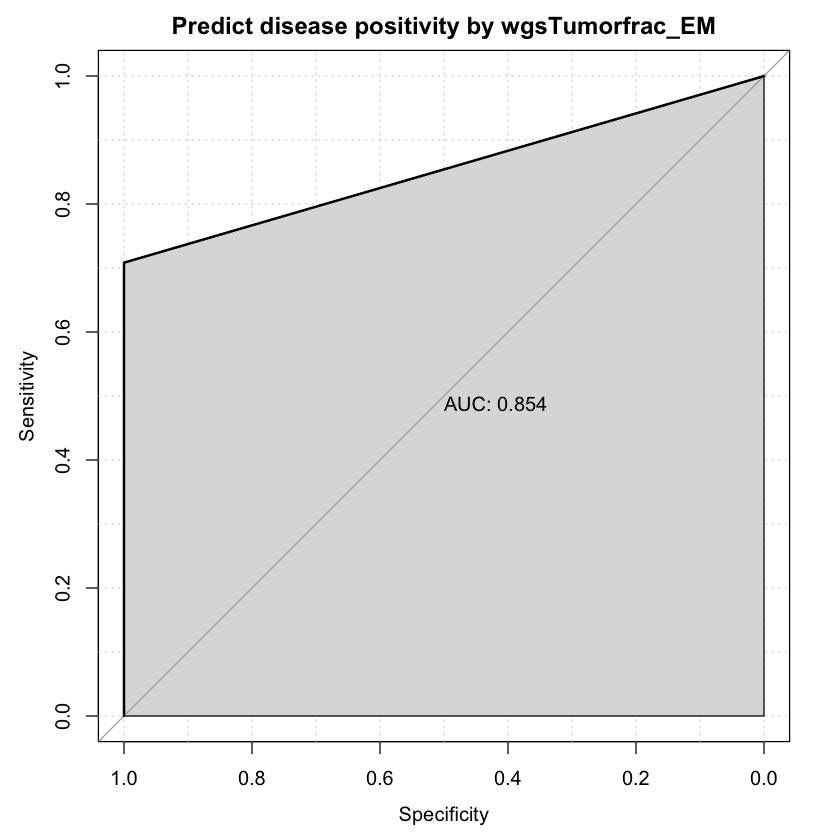

In [132]:
# correlation of LPWGS with disease positivity and prediction AUCs # rerun
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM')){
    options(repr.plot.width=5, repr.plot.height=5)
    g <- quick_boxplot(df_ngsqc.urine.mrd, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(df_ngsqc.urine.mrd, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}

## BEACON

In [25]:
# probe library accounting

df_samples_all = make_names(df_samples_all) %>% mutate(SampleID.short=make_SIDshort(SampleID,"strict"))

pipeline.probes = read_excel("hybrid_probe_mrd/probe_sets_02072024.xlsx", sheet="probe_sets_02072024") %>%
                    mutate(SampleID.short=make_SIDshort(file.sampleid,"strict"))

probes = df_samples_all %>% select(PatientID, SampleID.short, EX...QC, EPIC, MRD, WES., MRDprobe) %>%
                left_join(pipeline.probes, by="SampleID.short") %>% filter(!is.na(person))
head(probes)

write.csv(probe.summary %>% mutate(across(everything(), as.character)), "Probe_summary_02082024.csv", row.names=FALSE)

SampleID.short format: strict
SampleID.short format: strict


PatientID,SampleID.short,EX...QC,EPIC,MRD,WES.,MRDprobe,person,size,month,day,year,date,file,file.sampleid,suffix
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,7629,Nov,12,2024,Nov.12.2024,P228837_U_targets.rds,P228837,NA
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,5395,Sep,14,2024,Sep.14.2024,P228837_1_targets.rds,P228837,NA
116381,P228837,NA,WOP00631,NA,WOP00631,MRD2,pdu,5545,Aug,15,2024,Aug.15.2024,P228837_targets.rds,P228837,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,10039,Nov,12,2024,Nov.12.2024,P228839_U_targets.rds,P228839,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,7767,Sep,14,2024,Sep.14.2024,P228839_1_targets.rds,P228839,NA
152237,P228839,NA,WOP00631,NA,WOP00631,MRD2,pdu,7655,Aug,15,2024,Aug.15.2024,P228839_targets.rds,P228839,NA


In [27]:
probe.summary = probes %>% group_by(PatientID) %>% distinct(file, .keep_all=TRUE) %>% ungroup() %>%
                    pivot_wider(names_from = "date", values_from = "file",id_cols = "PatientID")
probe.summary

Warning message:
“Values from `file` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(PatientID, date) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”


PatientID,Nov.12.2024,Sep.14.2024,Aug.15.2024,Dec.3.2024,Oct.22.2022,Dec.3.2022,Jul.23.2023,Jul.26.2023,Aug.17.2024,Nov.4.2024,Jul.20.2023,Nov.5.2024,Jul.5.2023
<chr>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
116381,P228837_....,P228837_....,P228837_....,,,,,,,,,,
152237,P228839_....,P228839_....,P228839_....,,,,,,,,,,
161922,,,,P220081_....,P220081_....,,,,,,,,
165028,P228840_....,P228840_....,P228840_....,,,,,,,,,,
167162,P228841_....,P228842_....,P228842_....,,,,,,,,,,
169558,,,,P220073_....,P220073_....,,,,,,,,
171374,,,,,,P219772_....,,,,,,,
171769,,,,P220077_....,,,P219774_....,P219774p....,P220077_....,P220077_....,,,
171821,P228843_....,P228843_....,,,,,,P228675p....,P228843_....,,P228675_....,,


In [32]:
write.csv(probe.summary %>% mutate(across(everything(), as.character)), "Probe_summary_02082024.csv", row.names=FALSE)

In [35]:
samples = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_02052024.xlsx", sheet="SeqQC")
head(samples)

table(samples$SampleType, samples$Assay)


Assay,Shipping_Batch,SampleID,PatientID,SampleID.short,externalSampleID,StudyVisit,SampleType,Total.reads..M.,Mapped.reads..M.,Target unique fragment coverage,Consensus reads (M),Duplication.rate....,Target.unique.fragment.coverage,Target.read.coverage,Mean target read coverage,Percentage of target > 20% Mean coverage,Within 2-fold (%) after dedup,Within 2-fold (%) before dedup,onTarget rate (%),onTarget rate ext200 (%),gcRatio.low,gcRatio.high,Mean error rate (%) after dedup,background.50% after dedup,background.99% after dedup,Fragment_Size_Mode,Fragment_Size_Bandwidth,Softclip ratio,Double strand ratio,BC_totalCount,SNP_BC,Panel,Workorder
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
WES+,Batch 1,P217589,172602,P217589,NA,Pre-Repeat TURBT,Supernatant,1170,1160,99.7,527.0,54.7,5150,14400,15524,99.7,69.4,57.5,71.099999999999994,89.6,0.65800000000000003,1.46,0.00138,0.1300,0.605,136.1,118.3918,2.250,3.51,NA,12011010100110001011210000001110010',NA,NA
WES+,Batch 1,P217590,172851,P217590,NA,Pre-Repeat TURBT,Supernatant,1050,1050,99.8,480.0,54.1,5259,12400,15700,99.2,60.8,54.2,67.5,89.5,0.627,1.4,0.02530,0.1390,0.657,112.0,217.1263,0.643,100.00,25074931,20002001201102112000011110100001121',NA,NA
BEACON.index.baseline.only,Batch 1,P217590,172851,P217590,06S22022824,Pre-Repeat TURBT,Supernatant,NA,NA,8305.0,13.5,NA,NA,NA,NA,NA,83.0,NA,NA,NA,NA,NA,0.05480,0.0935,0.447,109.5,164.9924,2.610,3.51,5054107,20002001101102112000021110100001121',NA,NA
WES+,Batch 1,P217591,172586,P217591,NA,Pre-Repeat TURBT,Supernatant,1130,1130,99.8,475.0,57.8,5298,14600,15947,99.5,59.9,54.1,71.099999999999994,90.2,0.64300000000000002,1.41,0.02240,0.1290,0.587,109.5,116.1083,0.762,100.00,24124680,11102001100000001010210010000112021',NA,NA
BEACON.index.baseline.only,Batch 1,P217591,172586,P217591,06S22017463,Pre-Repeat TURBT,Supernatant,NA,NA,7315.0,12.1,NA,NA,NA,NA,NA,74.6,NA,NA,NA,NA,NA,0.04130,0.0837,0.432,91.4,103.7000,2.340,3.33,4361695,11102001100000001010210010000112021',NA,NA
BEACON.index.baseline.only,Batch 1,P217592,173983,P217592,06S22034638,Pre-Repeat TURBT,Supernatant,NA,NA,26655.0,36.0,NA,NA,NA,NA,NA,94.8,NA,NA,NA,NA,NA,0.06190,0.0583,0.428,156.1,185.3290,1.440,7.28,6315783,00011101101220010020101110102022021',NA,NA


             
              BEACON.hybrid.tissues BEACON.hybrid.urine.tissue
  FFPE                            0                          0
  Supernatant                    30                         23
  Tissue                          0                          0
  <NA>                            0                          0
             
              BEACON.index.baseline.only WES+ <NA>
  FFPE                                 0  134    0
  Supernatant                         19   40    0
  Tissue                               0   18    0
  <NA>                                 0    0    0

In [14]:
# prelim batch 4 mrd plots

## combine
mrd.info.4 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_4_mrd_data/WOP01633_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-14.csv")
head(mrd.info.4)

# mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/PD_mrd_analysis_batch5/WOP01651_WOP01646_WOP01656_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-13.csv")
# head(mrd.info.5)

df_ngsqc.preur <- mrd.info.4 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))

table(df_ngsqc.preur$StudyVisit.sample) 




,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219772,171374,P237609A01,16,16,0,17,17,16,13.75,12.500,13.75,TRUE,TRUE,1,0.007053956,0.006138926,0.006138926,1.800357,0.34851556,87.412,0.93283,0.93283,0.0176145,0.02024000,0.01761450,0.01643133,0.03537,0.03537034,PREDICINEMRD_V1B__P237609A01,P219772_20240304,06S21164690,Not_available,Pre-Repeat TURBT,Urine_Supernatant
2,P233058A01,182910,P233058A01,60,60,9,55,55,55,56.50,55.625,56.50,TRUE,FALSE,1,0.221126326,0.212642552,0.102967791,66.358758,0.06325032,62.809,0.77156,0.77156,3.3619206,3.49605078,1.62794105,1.25605420,0.78885,0.78885170,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
3,P233058A01,182910,P234621A01,50,50,35,45,41,41,42.75,35.875,42.75,TRUE,TRUE,5,0.017122260,0.015808092,0.013901435,65.128786,0.17468276,41.940,0.63566,0.50059,0.0904960,0.09801917,0.07958103,0.03983747,0.78882,0.16123759,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
4,P233058A01,182910,P234621A01_Specific,2,8,76,10,10,8,8.50,9.875,10.75,TRUE,TRUE,1,0.248158563,0.278794181,0.278794181,65.128786,NA,38.909,0.63566,0.63566,NA,NA,NA,NA,0.78882,0.78882413,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
5,P233058A01,182910,Pool,NA,NA,19,56,56,56,59.50,58.625,59.50,TRUE,FALSE,1,0.231783539,0.231542033,0.109258557,66.358758,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant
6,P233062A01,179692,P233062A01,26,26,34,10,9,9,9.00,8.250,9.00,TRUE,FALSE,1,0.088726697,0.088616778,0.088616778,18.524154,0.05225559,24.684,0.68012,0.39594,1.6958335,1.69793697,1.69583348,0.67144831,0.18027,0.18026615,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant


SampleID.short format: strict


[1] 52

 [1] "171374" "182910" "179692" "181439" "181568" "184485" "175831" "184615"
 [9] "184289" "184957" "186652" "185581" "185382" "185212" "182435" "187807"
[17] "188867" "187204" "189342" "189083" "190233" "186478" "191632" "192682"
[25] "193186"
SampleID.short format: strict


[1] 52

 [1] "171374" "182910" "179692" "181439" "181568" "184485" "175831" "184615"
 [9] "184289" "184957" "186652" "185581" "185382" "185212" "182435" "187807"
[17] "188867" "187204" "189342" "189083" "190233" "186478" "191632" "192682"
[25] "193186"


[1] 52

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219772,P237609A01,16,16,0,17,17,16,13.750,12.500,13.750,TRUE,TRUE,1,0.007053956,0.006138926,0.006138926,1.800357,0.34851556,87.4120,0.93283,0.93283,0.01761450,0.02024000,0.01761450,0.016431330,0.035370,0.035370338,PREDICINEMRD_V1B__P237609A01,P219772_20240304,06S21164690,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P219772,Pre-RepeatTURBT,171374,NA,171374,P237609,IndexTURBT,171374,171374
2,P233058A01,P233058A01,60,60,9,55,55,55,56.500,55.625,56.500,TRUE,FALSE,1,0.221126326,0.212642552,0.102967791,66.358758,0.06325032,62.8090,0.77156,0.77156,3.36192064,3.49605078,1.62794105,1.256054199,0.788850,0.788851705,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233058,Pre-RepeatTURBT,182910,NA,182910,P233058,Pre-RepeatTURBT,182910,182910
3,P233058A01,P234621A01,50,50,35,45,41,41,42.750,35.875,42.750,TRUE,TRUE,5,0.017122260,0.015808092,0.013901435,65.128786,0.17468276,41.9400,0.63566,0.50059,0.09049600,0.09801917,0.07958103,0.039837470,0.788820,0.161237590,PREDICINEMRD_V1B__P233058A01,P233058A01_20240304,06S22120827,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233058,Pre-RepeatTURBT,182910,NA,182910,P234621,IndexTURBT,182910,182910
4,P233062A01,P233062A01,26,26,34,10,9,9,9.000,8.250,9.000,TRUE,FALSE,1,0.088726697,0.088616778,0.088616778,18.524154,0.05225559,24.6840,0.68012,0.39594,1.69583348,1.69793697,1.69583348,0.671448309,0.180270,0.180266152,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P233062,Pre-RepeatTURBT,179692,179692
5,P233062A01,P234593A01,27,27,114,7,3,3,2.125,1.375,2.125,TRUE,TRUE,1,0.004221190,0.003582663,0.003582663,1.962923,0.20818115,4.8941,0.74783,0.13300,0.01720936,0.02027652,0.01720936,0.002288844,0.038503,0.002288844,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P234593,IndexTURBT,179692,179692
6,P233062A01,P237635A01,26,26,113,5,4,4,3.125,2.375,3.125,TRUE,TRUE,1,0.015007899,0.037589767,0.037589767,4.013066,0.35984848,7.5758,0.72811,0.14085,0.10445998,0.04170616,0.10445998,0.014713189,0.077165,0.077164648,PREDICINEMRD_V1B__P233062A01,P233062A01_20240304,06S22121171,Pre-Repeat TURBT,Pre-Repeat TURBT,Urine_Supernatant,P233062,Pre-RepeatTURBT,179692,NA,179692,P237635,RepeatTURBT,179692,179692


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P219772             1               0           0    0
  P233058A01          1               1           0    0
  P233062A01          1               1           1    0
  P233068A01          1               1           0    0
  P233070A01          1               1           0    0
  P233077A01          1               1           0    0
  P233080A01          1               1           0    0
  P233086A01          1               1           0    0
  P233092A01          1               1           0    0
  P233096A01          1               1           0    0
  P233100A01          1               1           0    0
  P233102A01          1               1           0    0
  P233106A01          1               1           0    0
  P233110A01          1               1           0    0
  P233116A01          1               1           0    0
  P233122A01          1               1           0    0
  P233128A01      


Pre-RepeatTURBT            <NA> 
             52               0 

,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,172602,P237608A01,64,64,110,38,5,4,4.250,4.000,5.250,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,0.46121988,12.658,0.40288,0.25316,0.04788545,0.03787628,0.04788545,0.01212268,0.044087000,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
2,P217589,172602,P220072,20,20,110,18,18,18,21.250,20.000,21.250,TRUE,FALSE,1,0.16020066,0.16036977,0.16036977,28.47358,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
3,P217589,172602,P220072_Specific,20,20,110,18,18,18,21.250,20.000,21.250,TRUE,FALSE,1,0.16020066,0.16036977,0.16036977,28.47358,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
4,P217589,172602,P217589,61,61,74,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.06018306,29.386,0.54871,0.45424,2.44561068,3.29025322,1.69463145,0.76976939,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
5,P217589,172602,P217589_Specific,61,61,74,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.06018306,29.386,0.54871,0.45424,2.44561068,3.29025322,1.69463145,0.76976939,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant
6,P217589,172602,Pool,NA,NA,229,55,6,4,4.250,4.250,5.500,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,NA,NA,NA,NA,NA,NA,NA,NA,0.009243093,NA,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant


SampleID.short format: strict


[1] 98

 [1] "172602" "196111" "196412" "195312" "195407" "195874" "195778" "195451"
 [9] "194650" "193330" "193187" "193248" "189953" "185159" "182170" "178919"
[17] "173743" "76224"  "194171" "192682"
SampleID.short format: strict


[1] 98

 [1] "172602" "196111" "196412" "195312" "195407" "195874" "195778" "195451"
 [9] "194650" "193330" "193187" "193248" "189953" "185159" "182170" "178919"
[17] "173743" "76224"  "194171" "192682"


[1] 98

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,P237608A01,64,64,110,38,5,4,4.25000,4.000,5.250,TRUE,TRUE,1,0.017469295,0.02208572,0.02208572,2.254050,0.46121988,12.6580,0.40288,0.253160,0.04788545,0.03787628,0.04788545,0.01212268,0.044087,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602
2,P217589,P220072,20,20,110,18,18,18,21.25000,20.000,21.250,TRUE,FALSE,1,0.160200655,0.16036977,0.16036977,28.473581,0.05688338,12.9410,0.25551,0.255510,2.81927307,2.81630010,2.81927307,0.72035246,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602
3,P217589,P217589,61,61,74,59,59,59,51.62500,50.375,51.625,TRUE,FALSE,1,0.198017506,0.14718433,0.10198811,28.473581,0.06018306,29.3860,0.54871,0.454240,2.44561068,3.29025322,1.69463145,0.76976939,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P217589,Pre-RepeatTURBT,172602,172602
4,P237535A01,P237645A01,11,11,86,4,4,4,3.62500,1.000,3.625,FALSE,TRUE,3,0.008026283,0.02976484,0.02976484,3.026863,NA,52.8530,0.69155,0.691550,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237645,RepeatTURBT,196111,196111
5,P237535A01,P237535A01,46,46,12,38,38,38,36.00000,33.375,36.000,TRUE,FALSE,3,0.020532884,0.01964849,0.01557436,5.923961,0.01263797,4.7365,0.65446,0.090446,1.55471896,1.62469791,1.23234651,0.11146081,0.076169,0.07616882,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237535,Pre-RepeatTURBT,196111,196111
6,P237537A01,P237651A01,53,53,18,56,51,49,54.58553,53.211,56.586,TRUE,TRUE,3,0.084720809,0.08377222,0.05913990,18.630296,0.33494474,95.0620,0.97468,0.974680,0.25010759,0.25293966,0.17656614,0.17209549,0.213570,0.21357285,PREDICINEMRD_V1B__P237651A01,P237537A01_20240308,06S23103343,Pre-Repeat TURBT,NA,Urine_Supernatant,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P217589             1               1           1    0
  P233155A01          1               0           1    0
  P237532A01          0               1           1    0
  P237535A01          0               1           1    0
  P237537A01          1               1           0    0
  P237538A01          1               1           0    0
  P237541A01          1               1           1    0
  P237543A01          1               1           1    0
  P237545A01          1               1           1    0
  P237546A01          1               1           1    0
  P237549A01          1               1           1    0
  P237551A01          1               1           1    0
  P237553A01          1               1           1    0
  P237557A01          1               1           1    0
  P237558A01          1               1           1    0
  P237561A01          1               1           0    0
  P237562A01      


Pre-RepeatTURBT            <NA> 
             98               0 

PatientID,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
<chr>,<dbl>,<dbl>,<lgl>
76224,1,3,TRUE
116381,1,3,TRUE
152237,0,0,FALSE
161922,1,0,FALSE
165028,1,4,TRUE
167162,0,4,TRUE


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,sampleFolder,externalSampleID,trialVisitNum,externalTrialVisitNum,SpecimenType,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,P217589,P237608A01,64,64,110,38,5,4,4.25000,4.000,5.250,TRUE,TRUE,1,0.017469295,0.022085723,0.022085723,2.2540502,0.46121988,12.658,0.40288,0.25316,0.04788545,0.03787628,0.04788545,0.01212268,0.044087,0.04408726,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602,1,1,TRUE
2,P217589,P220072,20,20,110,18,18,18,21.25000,20.000,21.250,TRUE,FALSE,1,0.160200655,0.160369768,0.160369768,28.4735812,0.05688338,12.941,0.25551,0.25551,2.81927307,2.81630010,2.81927307,0.72035246,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589_20240308,06S22017869,Not_available,Pre-Repeat TURBT,Urine_Supernatant,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602,1,1,TRUE
3,P237535A01,P237645A01,11,11,86,4,4,4,3.62500,1.000,3.625,FALSE,TRUE,3,0.008026283,0.029764841,0.029764841,3.0268634,NA,52.853,0.69155,0.69155,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237645A01,P237535A01_20240308,06S23105566,Pre-Repeat TURBT,NA,Urine_Supernatant,P237535,Pre-RepeatTURBT,196111,NA,196111,P237645,RepeatTURBT,196111,196111,0,1,TRUE
4,P237537A01,P237651A01,53,53,18,56,51,49,54.58553,53.211,56.586,TRUE,TRUE,3,0.084720809,0.083772220,0.059139901,18.6302960,0.33494474,95.062,0.97468,0.97468,0.25010759,0.25293966,0.17656614,0.17209549,0.213570,0.21357285,PREDICINEMRD_V1B__P237651A01,P237537A01_20240308,06S23103343,Pre-Repeat TURBT,NA,Urine_Supernatant,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412,0,3,TRUE
5,P237543A01,P237650A01,56,56,24,51,51,51,53.50000,53.500,53.500,TRUE,TRUE,0,0.005134004,0.004263219,0.003088336,0.8993872,0.05865776,18.681,0.39063,0.31481,0.07267954,0.08752472,0.05265008,0.01657477,0.016406,0.01640567,PREDICINEMRD_V1B__P237650A01,P237543A01_20240308,06S23092073,Pre-Repeat TURBT,NA,Urine_Supernatant,P237543,Pre-RepeatTURBT,195312,NA,195312,P237650,IndexTURBT,195312,195312,0,0,FALSE
6,P237543A01,P237644A01,5,5,85,3,3,1,1.25000,3.375,3.375,TRUE,TRUE,0,0.004980080,0.004980080,0.004980080,0.4722285,NA,50.000,0.64542,0.64542,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237650A01,P237543A01_20240308,06S23092073,Pre-Repeat TURBT,NA,Urine_Supernatant,P237543,Pre-RepeatTURBT,195312,NA,195312,P237644,RepeatTURBT,195312,195312,0,0,FALSE


   disease.positive tumorFraction StudyVisit.baseline
1              TRUE    4.4087e-02          IndexTURBT
2              TRUE    4.3661e-01         RepeatTURBT
3              TRUE            NA         RepeatTURBT
4              TRUE    2.1357e-01          IndexTURBT
5             FALSE    1.6406e-02          IndexTURBT
6             FALSE            NA         RepeatTURBT
7             FALSE    3.1469e-02          IndexTURBT
8             FALSE            NA         RepeatTURBT
9              TRUE    8.1994e-03          IndexTURBT
10             TRUE    6.4740e-03         RepeatTURBT
11            FALSE            NA         RepeatTURBT
12            FALSE    5.7224e-02          IndexTURBT
13             TRUE    1.1049e-01          IndexTURBT
14             TRUE    4.6788e-02          IndexTURBT
15             TRUE    4.6788e-02         RepeatTURBT
16             TRUE    3.1055e-01          IndexTURBT
17             TRUE    2.9536e-01         RepeatTURBT
18            FALSE    9.670

Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", labels = scaleFUN):
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


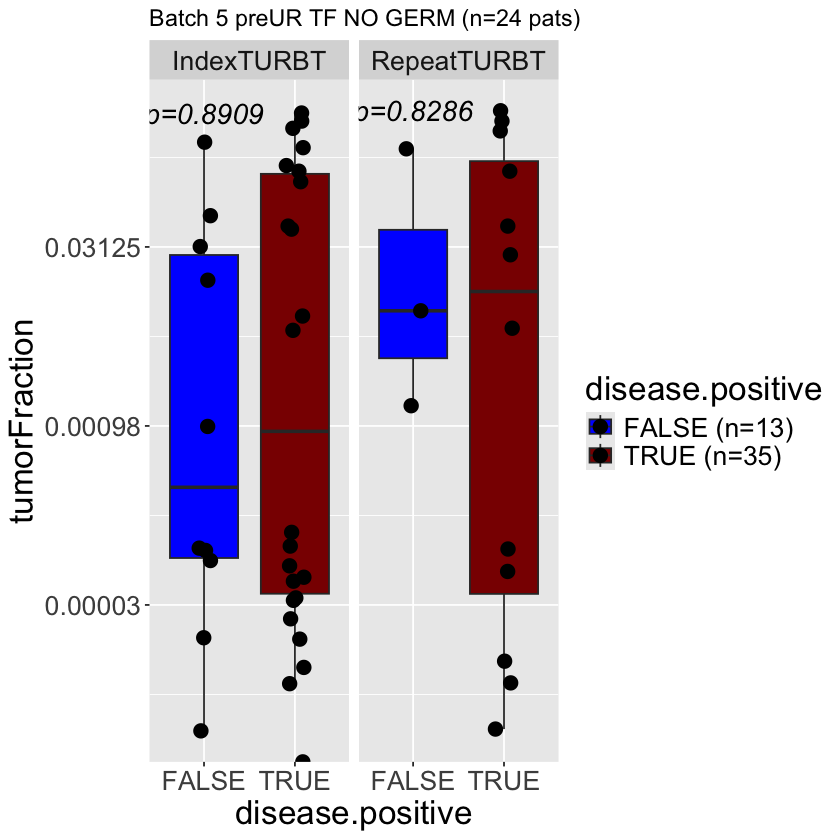

In [49]:
## batch 5 - no germ yet
source("~/Desktop/puffin/R/helper_functions.R")

mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/PD_mrd_analysis_batch5/WOP01651_WOP01646_WOP01656_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-03-13.csv")
head(mrd.info.5)

df_ngsqc.preur <- mrd.info.5 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))
#df_ngsqc.preur = df_ngsqc.preur %>% filter(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline) %>% relocate(PatientID, PatientID.baseline)


table(df_ngsqc.preur$StudyVisit.sample) 

# need new clin data for disease.positive for batch 5 patients
df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(disease.positive = (Repeat.Tumor > 0),
                                                PatientID = as.character(PatientID))
head(df_clin.new)

df_ngsqc.preur_ = df_ngsqc.preur %>% mutate(PatientID = as.character(PatientID),
                                           StudyVisit.baseline = trimws(as.character(StudyVisit.baseline))) %>% 
    left_join(df_clin.new, by=c("PatientID"="PatientID")) %>% filter(StudyVisit.baseline != "Pre-RepeatTURBT")
head(df_ngsqc.preur_)

quick_boxplot(df = df_ngsqc.preur_, x = "disease.positive", y="tumorFraction", facet = "StudyVisit.baseline",
              log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"), plot.title="Batch 5 preUR TF NO GERM (n=4)")


In [50]:
# batch 5 updated - PD to fix bugs - not run yet
source("~/Desktop/puffin/R/helper_functions.R")

mrd.info.5 = read.csv("hybrid_probe_mrd/hybrid_mrd_data/batch_5_mrd_data/WOP01646_WOP01656_WOP01651_PRDC-MOFFITT-NMIBC-22001_Other_all_2024-01-07_updated.csv")
head(mrd.info.5)

df_ngsqc.preur <- mrd.info.5 #rbind.common(mrd.info.5, mrd.info.4)
df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)

#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)),
                               Baseline.short = make_SIDshort(Baseline, "strict"))
nrow(df_ngsqc.preur)
### add baseline study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline.short"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))
nrow(df_ngsqc.preur)
head(df_ngsqc.preur)
#df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")

# interesting to check TF of urine sampleID vs. basline=sampleID. Do we get TF.WES==TF.BEACON?
table(df_ngsqc.preur$SampleID.sample, df_ngsqc.preur$StudyVisit.baseline)

stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline))
#df_ngsqc.preur = df_ngsqc.preur %>% filter(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline) %>% relocate(PatientID, PatientID.baseline)


table(df_ngsqc.preur$StudyVisit.sample) 

df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(disease.positive = (Repeat.Tumor > 0),
                                                PatientID = as.character(PatientID))
head(df_clin.new)

df_ngsqc.preur_ = df_ngsqc.preur %>% mutate(PatientID = as.character(PatientID),
                                           StudyVisit.baseline = trimws(as.character(StudyVisit.baseline))) %>% 
    left_join(df_clin.new, by=c("PatientID"="PatientID")) %>% filter(StudyVisit.baseline != "Pre-RepeatTURBT")
head(df_ngsqc.preur_)

quick_boxplot(df = df_ngsqc.preur_, x = "disease.positive", y="tumorFraction", facet = "StudyVisit.baseline",
              log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"), plot.title="Batch 5 preUR TF NO GERM (n=18 pats)")


,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,P217589,172602,P237608A01,66,66,93,38,5,3,3.250,4.000,5.250,TRUE,TRUE,1,0.01643517,0.02253594,0.02253594,2.22439,0.61093164,12.6580,0.40288,0.25316,0.03688783,0.03563412,0.03688783,0.009338522,0.043520000,0.04351976,PREDICINEMRD_V1B__P237608A01
2,P217589,172602,P220072,20,20,112,17,5,5,5.625,4.375,5.625,TRUE,TRUE,1,0.15700157,0.17055201,0.17055201,24.13925,0.21789905,6.8736,0.25551,0.19101,0.78271109,1.10542443,0.78271109,0.149505645,0.365310000,0.36531175,PREDICINEMRD_V1B__P237608A01
3,P217589,172602,P220072_Specific,20,20,112,17,5,5,5.625,4.375,5.625,TRUE,TRUE,1,0.15700157,0.17055201,0.17055201,24.13925,0.21789905,6.8736,0.25551,0.19101,0.78271109,1.10542443,0.78271109,0.149505645,0.365310000,0.36531175,PREDICINEMRD_V1B__P237608A01
4,P217589,172602,P217589,61,61,71,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.05984647,29.3860,0.54871,0.45424,2.45936525,3.29025322,1.70416238,0.774098718,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01
5,P217589,172602,P217589_Specific,61,61,71,59,59,59,51.625,50.375,51.625,TRUE,FALSE,1,0.19801751,0.14718433,0.10198811,28.47358,0.05984647,29.3860,0.54871,0.45424,2.45936525,3.29025322,1.70416238,0.774098718,0.436610000,0.43661473,PREDICINEMRD_V1B__P237608A01
6,P217589,NA,Pool,NA,NA,80,50,9,4,4.250,7.250,8.500,TRUE,TRUE,1,0.01746929,0.02208572,0.02208572,2.25405,NA,NA,NA,NA,NA,NA,NA,NA,0.009243093,NA,PREDICINEMRD_V1B__P237608A01


SampleID.short format: strict


[1] 12

[1] "172602" "196412" "195407" "193248" "189953"
SampleID.short format: strict


[1] 12

[1] "172602" "196412" "195407" "193248" "189953"


[1] 12

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217589,P237608A01,66,66,93,38,5,3,3.25000,4.000,5.250,TRUE,TRUE,1,0.016435165,0.022535941,0.0225359409,2.224390,0.61093164,12.6580,0.40288,0.25316,0.036887828,0.035634121,0.036887828,0.0093385224,0.043520,0.04351976,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602
2,P217589,P220072,20,20,112,17,5,5,5.62500,4.375,5.625,TRUE,TRUE,1,0.157001567,0.170552006,0.1705520057,24.139250,0.21789905,6.8736,0.25551,0.19101,0.782711087,1.105424434,0.782711087,0.1495056448,0.365310,0.36531175,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602
3,P217589,P217589,61,61,71,59,59,59,51.62500,50.375,51.625,TRUE,FALSE,1,0.198017506,0.147184333,0.1019881056,28.473581,0.05984647,29.3860,0.54871,0.45424,2.459365254,3.290253224,1.704162377,0.7740987179,0.436610,0.43661473,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P217589,Pre-RepeatTURBT,172602,172602
4,P237537A01,P237651A01,53,53,131,35,32,29,26.71053,27.586,29.711,TRUE,TRUE,3,0.043937073,0.048646644,0.0486466440,18.630296,0.30333855,95.0620,0.97468,0.97468,0.160370794,0.143522987,0.160370794,0.1563102052,0.314090,0.31409002,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412
5,P237537A01,P237537A01,57,57,106,58,57,57,54.23026,52.105,54.230,TRUE,FALSE,3,0.086906748,0.084454674,0.0531086839,23.670886,0.04258735,24.2980,0.36614,0.36614,1.983092931,2.040670455,1.247053009,0.4565959886,0.382800,0.38280450,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237537,Pre-RepeatTURBT,196412,196412
6,P237545A01,P237619A01,67,67,106,59,54,53,36.98369,36.984,36.984,TRUE,TRUE,0,0.001318306,0.000543251,0.0003847813,1.598607,0.21765569,34.9650,0.67510,0.51852,0.002495919,0.006030404,0.001767844,0.0009166626,0.031469,0.03146908,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237619,IndexTURBT,195407,195407


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  P217589             1               1           1    0
  P237537A01          1               1           0    0
  P237545A01          1               1           1    0
  P237577A01          1               1           0    0
  P237583A01          1               1           0    0
  <NA>                0               0           0    0


Pre-RepeatTURBT            <NA> 
             12               0 

PatientID,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
<chr>,<dbl>,<dbl>,<lgl>
76224,1,3,TRUE
116381,1,3,TRUE
152237,0,0,FALSE
161922,1,0,FALSE
165028,1,4,TRUE
167162,0,4,TRUE


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.sig,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,Panel,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,Baseline.short,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,Recurrence.Follow.Up,Repeat.Tumor,disease.positive
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,P217589,P237608A01,66,66,93,38,5,3,3.25000,4.000,5.250,TRUE,TRUE,1,0.016435165,0.022535941,0.0225359409,2.224390,0.6109316,12.6580,0.40288,0.25316,0.036887828,0.035634121,0.036887828,0.0093385224,0.043520,0.04351976,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P237608,IndexTURBT,172602,172602,1,1,TRUE
2,P217589,P220072,20,20,112,17,5,5,5.62500,4.375,5.625,TRUE,TRUE,1,0.157001567,0.170552006,0.1705520057,24.139250,0.2178991,6.8736,0.25551,0.19101,0.782711087,1.105424434,0.782711087,0.1495056448,0.365310,0.36531175,PREDICINEMRD_V1B__P237608A01,P217589,Pre-RepeatTURBT,172602,NA,172602,P220072,RepeatTURBT,172602,172602,1,1,TRUE
3,P237537A01,P237651A01,53,53,131,35,32,29,26.71053,27.586,29.711,TRUE,TRUE,3,0.043937073,0.048646644,0.0486466440,18.630296,0.3033385,95.0620,0.97468,0.97468,0.160370794,0.143522987,0.160370794,0.1563102052,0.314090,0.31409002,PREDICINEMRD_V1B__P237651A01,P237537,Pre-RepeatTURBT,196412,NA,196412,P237651,IndexTURBT,196412,196412,0,3,TRUE
4,P237545A01,P237619A01,67,67,106,59,54,53,36.98369,36.984,36.984,TRUE,TRUE,0,0.001318306,0.000543251,0.0003847813,1.598607,0.2176557,34.9650,0.67510,0.51852,0.002495919,0.006030404,0.001767844,0.0009166626,0.031469,0.03146908,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237619,IndexTURBT,195407,195407,NA,0,FALSE
5,P237545A01,P237643A01,5,5,161,4,3,0,0.00000,0.000,0.000,FALSE,FALSE,0,NA,NA,NA,NA,NA,49.5650,0.66279,0.66279,NA,NA,NA,NA,NA,NA,PREDICINEMRD_V1B__P237619A01,P237545,Pre-RepeatTURBT,195407,NA,195407,P237643,RepeatTURBT,195407,195407,NA,0,FALSE
6,P237577A01,P237620A01,42,42,122,31,31,31,28.12500,25.375,28.125,TRUE,FALSE,4,0.331888173,0.269050513,0.2690505132,57.582774,0.2347148,69.4440,0.79775,0.79775,1.146286889,1.414006078,1.146286889,0.9144503658,0.730830,0.73082574,PREDICINEMRD_V1B__P237620A01,P237577,Pre-RepeatTURBT,193248,NA,193248,P237620,IndexTURBT,193248,193248,0,3,TRUE


  disease.positive tumorFraction StudyVisit.baseline
1             TRUE     0.0435200          IndexTURBT
2             TRUE     0.3653100         RepeatTURBT
3             TRUE     0.3140900          IndexTURBT
4            FALSE     0.0314690          IndexTURBT
5            FALSE            NA         RepeatTURBT
6             TRUE     0.7308300          IndexTURBT
7             TRUE     0.0062167          IndexTURBT
Complete cases tumorFraction by disease.positive: 6
[1] "FALSE" "TRUE" 
      disease.positive count      legend   color
FALSE            FALSE     1 FALSE (n=1)    blue
TRUE              TRUE     5  TRUE (n=5) darkred
[1] "y"
  disease.positive tumorFraction StudyVisit.baseline
1             TRUE     0.0435200          IndexTURBT
2             TRUE     0.3653100         RepeatTURBT
3             TRUE     0.3140900          IndexTURBT
4            FALSE     0.0314690          IndexTURBT
6             TRUE     0.7308300          IndexTURBT
7             TRUE     0.006216

ERROR: Error in wilcox.test.default(lev1_vals, not_lev1_vals, exact = FALSE, : not enough (non-missing) 'x' observations
